<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/new_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax

In [ ]:
# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    r2_values = []
    for i in range(len(W_all)):
        Y_pred = X_wins[i] @ W_all[i]
        ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
        ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        r2_values.append(r2)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [jnp.array(r2_values)],
        'method_used': f'jax_{constraint_method}'
    }


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows(X, window_size, stride)
                Y_wins = create_windows(residual, window_size, stride)
                W_layer = jnp.stack([solve_ols(X_wins[i], Y_wins[i])
                                   for i in range(len(X_wins))])

                # Compute R²
                r2_values = []
                for i in range(len(W_layer)):
                    Y_pred = X_wins[i] @ W_layer[i]
                    ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
                    ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_values.append(r2)

                results = {
                    'W_all': W_layer,
                    'r2': [jnp.array(r2_values)]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }

Running example...

Unified Sliding Regression Extended
  Method: jax
  Data: 1256 samples, 7 features, 168 outputs
  Windows: requested size 200, stride 150
  Countries: 12  Tenors: 14

Phase 1: Discovering zero patterns...
  Effective windows: 8 (size 200, stride 150)
  Discovered 121 zeros (10.3% sparsity)

Phase 2: Applying jax regression...

Completed in 13.513 seconds
  Zero violations: max=nan, count=3
  Offset violations: max=1.47e+01
  Fixed violations: max=2.98e-08
  Positive constraint violations: max=7.14e-01
  Negative constraint violations: max=2.61e-01
  Mean R²: nan


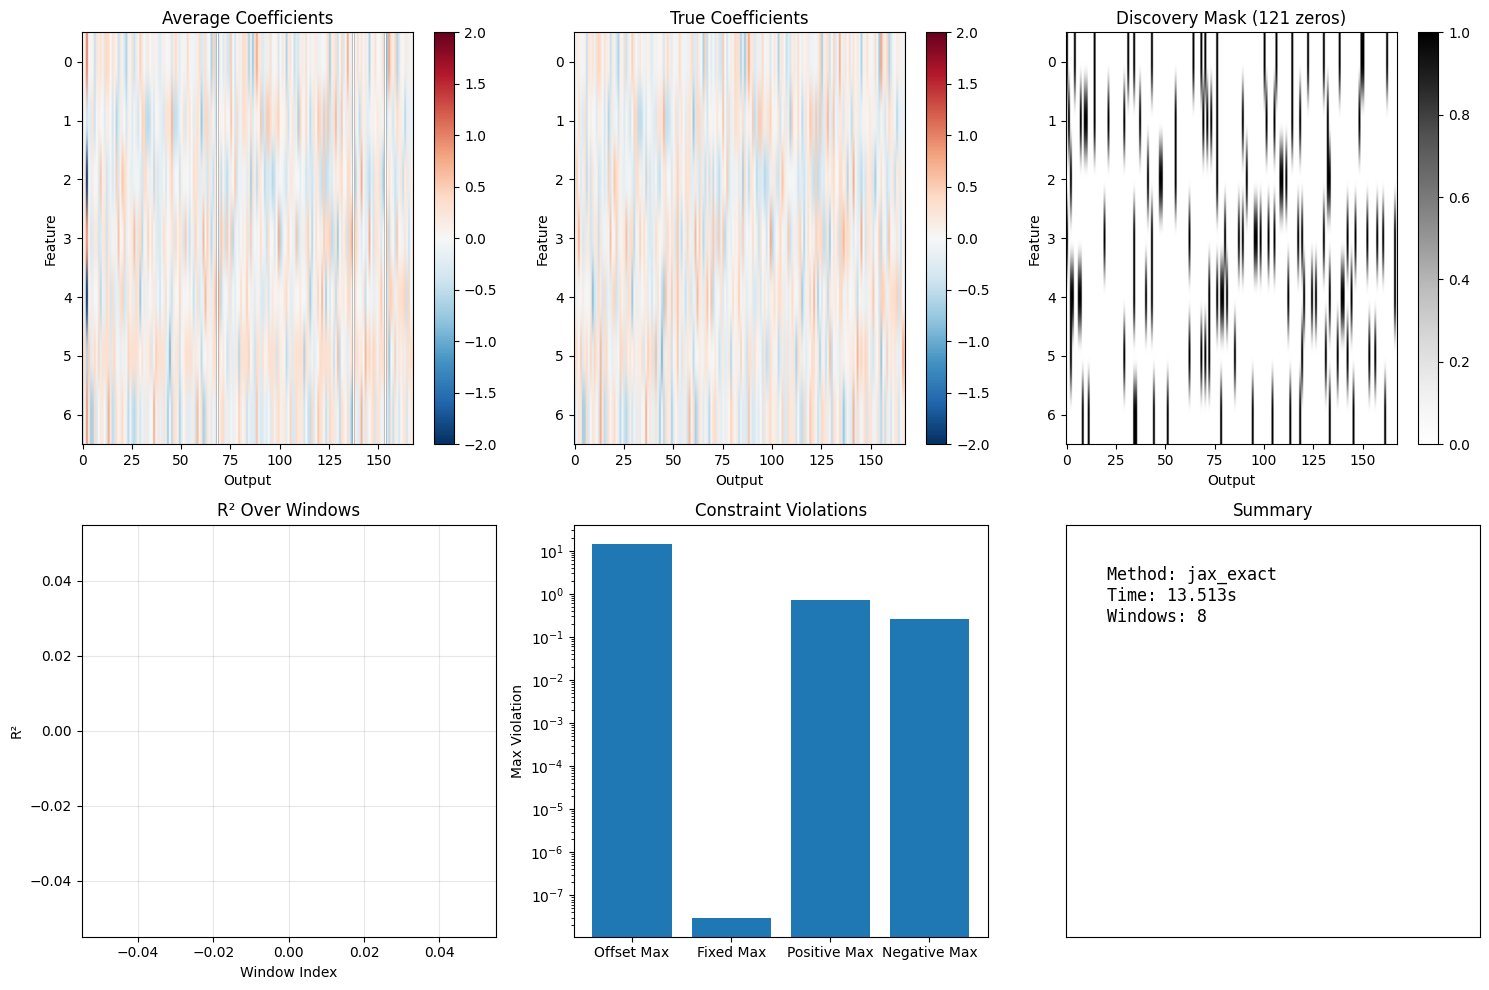

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


# =============================== WINDOWING ===============================

def create_windows(data, window_size, stride):
    """Create sliding windows, guaranteeing >=1 window (data unchanged)."""
    n_samples = int(data.shape[0])
    if stride <= 0:
        raise ValueError("stride must be > 0")

    # If the requested window is longer than the data, clamp to full length
    eff_window = min(int(window_size), n_samples)

    if n_samples <= eff_window:
        # One window: the whole series
        return jnp.array(data[None, :eff_window, ...])

    n_windows = (n_samples - eff_window) // stride + 1
    if n_windows <= 0:
        # One window: last eff_window samples
        start = n_samples - eff_window
        return jnp.array(data[None, start:start+eff_window, ...])

    idx0 = np.arange(n_windows)[:, None] * stride
    idx1 = np.arange(eff_window)[None, :]
    indices = idx0 + idx1
    return jnp.array(data[indices])


def create_windows_vectorized(data, window_size, stride):
    """Alias to create_windows; kept for compatibility."""
    return create_windows(data, window_size, stride)


# ============================ INDEX & PLANNER ============================

def output_index(c: int, t: int, n_tenors: int) -> int:
    return c * n_tenors + t

def output_ct_from_j(j: int, n_tenors: int):
    return (j // n_tenors, j % n_tenors)

def output_index_from_lists(country_idx: int, tenor_idx: int, tenor_list) -> int:
    """(country_pos, tenor_pos) -> flat output index, country-major then tenor."""
    return country_idx * len(tenor_list) + tenor_idx

def output_ct_from_j_using_lists(j: int, tenor_list):
    """flat output index -> (country_pos, tenor_pos)."""
    n_tenors = len(tenor_list)
    return (j // n_tenors, j % n_tenors)


def _normalize_selector(sel, max_len):
    if sel is None or sel == 'all':
        return list(range(max_len))
    if isinstance(sel, slice):
        return list(range(*sel.indices(max_len)))
    if isinstance(sel, range):
        return list(sel)
    return sorted(set(int(x) for x in sel))

def build_per_output_constraints_from_lists(country_list, tenor_list, n_features, constraints_config):
    """
    Expand country/tenor-scoped rules into per-output constraints.
    country_list / tenor_list can be strings or ints; positions define indices.
    """
    n_countries, n_tenors = len(country_list), len(tenor_list)
    n_outputs = n_countries * n_tenors
    per_output = {j: {'offset_pairs': [], 'fixed': [], 'positive': [], 'negative': [], 'zeros': []}
                  for j in range(n_outputs)}
    if constraints_config is None:
        constraints_config = {}

    def _normalize_selector(sel, max_len):
        if sel is None or sel == 'all':
            return list(range(max_len))
        if isinstance(sel, slice):
            return list(range(*sel.indices(max_len)))
        if isinstance(sel, range):
            return list(sel)
        return sorted(set(int(x) for x in sel))

    # Backward compatible globals
    glob_offsets = constraints_config.get('offset_indices', None)
    if glob_offsets is not None:
        if isinstance(glob_offsets, tuple):
            glob_offsets = [glob_offsets]
        for j in range(n_outputs):
            per_output[j]['offset_pairs'].extend(glob_offsets)

    glob_fixed = constraints_config.get('fixed_constraints', None)
    if glob_fixed is not None:
        for j in range(n_outputs):
            per_output[j]['fixed'].extend(glob_fixed)

    glob_pos = constraints_config.get('positive_constraints', None)
    if glob_pos is not None:
        for j in range(n_outputs):
            per_output[j]['positive'].extend(glob_pos)

    glob_neg = constraints_config.get('negative_constraints', None)
    if glob_neg is not None:
        for j in range(n_outputs):
            per_output[j]['negative'].extend(glob_neg)

    # Country/tenor-scoped
    cr = constraints_config.get('country_rules', {})

    for rule in cr.get('offset', []):
        i1, i2 = rule['pair']
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['offset_pairs'].append((int(i1), int(i2)))

    for rule in cr.get('fixed', []):
        idx, val = int(rule['idx']), float(rule['value'])
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['fixed'].append((idx, val))

    for rule in cr.get('sign', []):
        pos = [int(x) for x in rule.get('positive', [])]
        neg = [int(x) for x in rule.get('negative', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['positive'].extend(pos)
                per_output[j]['negative'].extend(neg)

    for rule in cr.get('zero', []):
        idxs = [int(x) for x in rule.get('indices', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['zeros'].extend(idxs)

    # Dedup & bounds
    for j in range(n_outputs):
        d = per_output[j]
        d['offset_pairs'] = list({tuple(x) for x in d['offset_pairs']})
        d['fixed']        = list({(i, float(v)) for (i, v) in d['fixed']})
        d['positive']     = sorted(set(d['positive']))
        d['negative']     = sorted(set(d['negative']))
        d['zeros']        = sorted(set(d['zeros']))
        for i in d['positive'] + d['negative'] + d['zeros'] + [p for pair in d['offset_pairs'] for p in pair] + [i for (i, _) in d['fixed']]:
            if not (0 <= i < n_features):
                raise ValueError(f"Feature index {i} out of range for output {j}")

    return per_output


def build_per_output_constraints(n_countries, n_tenors, n_features, constraints_config):
    """
    Expand country/tenor-scoped rules into per-output constraints.
    Returns dict j -> {'offset_pairs','fixed','positive','negative','zeros'}.
    """
    n_outputs = n_countries * n_tenors
    per_output = {j: {'offset_pairs': [], 'fixed': [], 'positive': [], 'negative': [], 'zeros': []}
                  for j in range(n_outputs)}
    if constraints_config is None:
        constraints_config = {}

    # Global (backward compatible)
    glob_offsets = constraints_config.get('offset_indices', None)
    if glob_offsets is not None:
        if isinstance(glob_offsets, tuple):
            glob_offsets = [glob_offsets]
        for j in range(n_outputs):
            per_output[j]['offset_pairs'].extend(glob_offsets)

    glob_fixed = constraints_config.get('fixed_constraints', None)
    if glob_fixed is not None:
        for j in range(n_outputs):
            per_output[j]['fixed'].extend(glob_fixed)

    glob_pos = constraints_config.get('positive_constraints', None)
    if glob_pos is not None:
        for j in range(n_outputs):
            per_output[j]['positive'].extend(glob_pos)

    glob_neg = constraints_config.get('negative_constraints', None)
    if glob_neg is not None:
        for j in range(n_outputs):
            per_output[j]['negative'].extend(glob_neg)

    # Country rules
    cr = constraints_config.get('country_rules', {})

    for rule in cr.get('offset', []):
        i1, i2 = rule['pair']
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['offset_pairs'].append((int(i1), int(i2)))

    for rule in cr.get('fixed', []):
        idx, val = int(rule['idx']), float(rule['value'])
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['fixed'].append((idx, val))

    for rule in cr.get('sign', []):
        pos = [int(x) for x in rule.get('positive', [])]
        neg = [int(x) for x in rule.get('negative', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['positive'].extend(pos)
                per_output[j]['negative'].extend(neg)

    for rule in cr.get('zero', []):
        idxs = [int(x) for x in rule.get('indices', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['zeros'].extend(idxs)

    # Dedup & bounds
    for j in range(n_outputs):
        d = per_output[j]
        d['offset_pairs'] = list({tuple(x) for x in d['offset_pairs']})
        d['fixed']        = list({(i, float(v)) for (i, v) in d['fixed']})
        d['positive']     = sorted(set(d['positive']))
        d['negative']     = sorted(set(d['negative']))
        d['zeros']        = sorted(set(d['zeros']))
        for i in d['positive'] + d['negative'] + d['zeros'] + [p for pair in d['offset_pairs'] for p in pair] + [i for (i, _) in d['fixed']]:
            if not (0 <= i < n_features):
                raise ValueError(f"Feature index {i} out of range for output {j}")

    return per_output


# =============================== SOLVERS ================================

def solve_ols(X, Y, reg=1e-6):
    """Basic Ridge-regularized OLS (matrix right-hand-side allowed)."""
    n_features = X.shape[1]
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(n_features), XtY)

def _build_Cd_for_output(n_features, fixed_list, offset_pairs, zero_indices):
    """
    Build equality constraint matrix C and rhs d for:
      - fixed: w[i] = val
      - zeros: w[i] = 0
      - offsets: w[i1] + w[i2] = 0
    Returns (C, d) with shape (m, n_features), (m,)
    """
    rows = []
    rhs  = []

    # fixed equalities
    for (i, v) in fixed_list:
        r = np.zeros(n_features, dtype=float); r[i] = 1.0
        rows.append(r); rhs.append(float(v))

    # zeros
    for i in zero_indices:
        r = np.zeros(n_features, dtype=float); r[i] = 1.0
        rows.append(r); rhs.append(0.0)

    # offset equalities
    for (i1, i2) in offset_pairs:
        r = np.zeros(n_features, dtype=float); r[i1] = 1.0; r[i2] = 1.0
        rows.append(r); rhs.append(0.0)

    if not rows:
        return jnp.zeros((0, n_features)), jnp.zeros((0,))
    C = jnp.array(np.stack(rows, axis=0))
    d = jnp.array(np.array(rhs))
    return C, d

def solve_kkt_constrained(X, y, n_features, fixed_list, offset_pairs, zero_indices, reg=1e-6):
    """
    Exact equality-constrained ridge regression via KKT:
      minimize ||Xw - y||^2 + reg||w||^2  s.t. C w = d
    Returns w (n_features,)
    """
    C, d = _build_Cd_for_output(n_features, fixed_list, offset_pairs, zero_indices)
    XtX = X.T @ X
    A = 2.0 * XtX + 2.0 * reg * jnp.eye(n_features)
    rhs_w = 2.0 * (X.T @ y)

    if C.shape[0] == 0:
        # no equalities
        return jnp.linalg.solve(A, rhs_w)

    # Build KKT system
    m = C.shape[0]
    K_top = jnp.concatenate([A, C.T], axis=1)
    K_bot = jnp.concatenate([C, jnp.zeros((m, m))], axis=1)
    K = jnp.concatenate([K_top, K_bot], axis=0)
    rhs = jnp.concatenate([rhs_w, d], axis=0)

    sol = jnp.linalg.solve(K, rhs)
    w = sol[:n_features]
    return w


# ========================== DISCOVERY (SPARSITY) ========================

def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Detect persistent near-zero coefficients across windows."""
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    small_mask = W_abs_mean < magnitude_threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    candidate_mask = small_mask | relative_mask

    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }
    return discovery_mask, stats



# ============================== MAIN API ================================
from time import time as get_time

def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    country_list,            # NEW: e.g., ['BE','DE',... ] or range(12)
    tenor_list,              # NEW: e.g., [1,3,6,12,...] or range(14)
    method: str = 'jax',
    layers: list = None,
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:

    start_time = get_time()
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_countries, n_tenors = len(country_list), len(tenor_list)

    if discovery_config is None: discovery_config = {}
    if constraints_config is None: constraints_config = {}
    if cvxpy_config is None: cvxpy_config = {}

    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: requested size {window_size}, stride {stride}")
    print(f"  Countries: {n_countries}  Tenors: {n_tenors}")

    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # Phase 1: discovery
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}
    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)
        print(f"  Effective windows: {int(X_wins.shape[0])} (size {int(X_wins.shape[1])}, stride {stride})")
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = jnp.array(discovery_mask) | jnp.array(forced_mask)
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {int(n_zeros)} zeros ({sparsity:.1f}% sparsity)")

    # Build per-output constraints using lists
    per_output_constraints = build_per_output_constraints_from_lists(
        country_list=country_list,
        tenor_list=tenor_list,
        n_features=n_features,
        constraints_config=constraints_config
    )

    print(f"\nPhase 2: Applying {method} regression...")
    constraint_method = constraints_config.get('method', 'exact')

    if layers:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints,
            cvxpy_config=cvxpy_config
        )
    else:
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method in ('cvxpy', 'hybrid'):
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                cvxpy_config=cvxpy_config
            )
            if method == 'hybrid':
                results['method_used'] = 'hybrid'
        else:
            raise ValueError(f"Unknown method: {method}")

    # Post
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(W_avg, discovery_mask, per_output_constraints)
    results['violations'] = violations

    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': int(create_windows(X, window_size, stride).shape[0]),
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config,
        'country_list': list(country_list),
        'tenor_list': list(tenor_list)
    }

    results['computation_time'] = get_time() - start_time
    print(f"\nCompleted in {results['computation_time']:.3f} seconds")
    print_summary(results)
    return results

def unified_sliding_regression_extended_old(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',   # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:

    start_time = time.time()

    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]

    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: requested size {window_size}, stride {stride}")

    # check cvxpy availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # --------- PHASE 1: DISCOVERY ----------
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)
        print(f"  Effective windows: {int(X_wins.shape[0])} (size {int(X_wins.shape[1])}, stride {stride})")

        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = jnp.array(discovery_mask) | jnp.array(forced_mask)

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {int(n_zeros)} zeros ({sparsity:.1f}% sparsity)")

    # --------- PHASE 2: REGRESSION ----------
    print(f"\nPhase 2: Applying {method} regression...")

    constraint_method = constraints_config.get('method', 'exact')

    # country/tenor → per-output expansion
    per_output_constraints = build_per_output_constraints(
        n_countries=n_countries,
        n_tenors=n_tenors,
        n_features=n_features,
        constraints_config=constraints_config
    )

    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints,
            cvxpy_config=cvxpy_config
        )
    else:
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method in ('cvxpy', 'hybrid'):
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                cvxpy_config=cvxpy_config
            )
            if method == 'hybrid':
                results['method_used'] = 'hybrid'
        else:
            raise ValueError(f"Unknown method: {method}")

    # --------- POST-PROCESSING ----------
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask,
        per_output_constraints=per_output_constraints
    )
    results['violations'] = violations

    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': int(create_windows(X, window_size, stride).shape[0]),
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    results['computation_time'] = time.time() - start_time
    print(f"\nCompleted in {results['computation_time']:.3f} seconds")
    print_summary(results)
    return results


# ============================= JAX METHODS ==============================

def apply_jax_regression(X, Y, window_size, stride,
                         constraint_method='exact',
                         discovery_mask=None,
                         constraints_config=None,
                         per_output_constraints=None):
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = int(X_wins.shape[0])
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    if constraint_method == 'exact':
        # KKT equality constraints per output (fixed, offset, zeros)
        for w in range(n_windows):
            Xw = X_wins[w]
            Yw = Y_wins[w]
            Ww = jnp.zeros((n_features, n_outputs))
            for j in range(n_outputs):
                poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'zeros':[]}
                zeros_j = list(poc.get('zeros', []))
                # add discovery zeros for this output
                if discovery_mask is not None:
                    zeros_j = sorted(set(zeros_j) | set(np.where(np.array(discovery_mask)[:, j])[0].tolist()))
                wj = solve_kkt_constrained(
                    Xw, Yw[:, j],
                    n_features=n_features,
                    fixed_list=poc.get('fixed', []),
                    offset_pairs=poc.get('offset_pairs', []),
                    zero_indices=zeros_j,
                    reg=1e-6
                )
                Ww = Ww.at[:, j].set(wj)
            W_all.append(Ww)
        W_all = jnp.stack(W_all)

    else:
        # Penalty method (soft equalities; sign via CVXPY)
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints
        )

    # R^2 per window
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': f'jax_{constraint_method}'
    }


def apply_penalty_constraints(X, Y, window_size, stride,
                              discovery_mask=None,
                              constraints_config=None,
                              per_output_constraints=None,
                              zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = int(X_wins.shape[0])
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    reg = 1e-6

    W_all = []

    for w in range(n_windows):
        Xw = X_wins[w]
        Yw = Y_wins[w]
        XtX = Xw.T @ Xw
        XtY = Xw.T @ Yw
        Ww = jnp.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'zeros':[]}
            penalty_matrix = reg * jnp.eye(n_features)

            # offsets -> soft equality
            for (i1, i2) in poc.get('offset_pairs', []):
                M = jnp.zeros((n_features, n_features))
                M = M.at[i1, i1].add(offset_penalty)
                M = M.at[i2, i2].add(offset_penalty)
                M = M.at[i1, i2].add(offset_penalty)
                M = M.at[i2, i1].add(offset_penalty)
                penalty_matrix = penalty_matrix + M

            # discovery zeros
            if discovery_mask is not None:
                zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
                penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

            # per-output zeros
            if poc.get('zeros'):
                zdiag = jnp.zeros(n_features).at[jnp.array(poc['zeros'])].set(zero_penalty)
                penalty_matrix = penalty_matrix + jnp.diag(zdiag)

            XtY_mod = XtY[:, j].copy()
            for (fidx, fval) in poc.get('fixed', []):
                penalty_matrix = penalty_matrix.at[fidx, fidx].add(fixed_penalty)
                XtY_mod = XtY_mod.at[fidx].add(fixed_penalty * fval)

            A = XtX + penalty_matrix
            wj = jnp.linalg.solve(A, XtY_mod)
            Ww = Ww.at[:, j].set(wj)

        W_all.append(Ww)

    return jnp.stack(W_all)


# ============================ VECTORIZED PATH ===========================

def _constraints_homogeneous(per_output_constraints, n_outputs):
    if per_output_constraints is None:
        return True
    ref = per_output_constraints[0]
    for j in range(1, n_outputs):
        if per_output_constraints[j] != ref:
            return False
    return True

def apply_vectorized_regression(X, Y, window_size, stride,
                                discovery_mask=None,
                                constraints_config=None,
                                per_output_constraints=None):
    """
    Vectorized fast path if constraints are homogeneous across outputs and simple.
    Otherwise, falls back to a per-output penalty solve (still batched over windows).
    """
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    n_windows, _, n_features = X_wins.shape
    n_outputs = Y.shape[1]
    reg = 1e-6

    if _constraints_homogeneous(per_output_constraints, n_outputs):
        # Use classic vectorized OLS + (optional) discovery zeros
        XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
        XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)
        I = jnp.eye(n_features)
        XtX_reg = XtX + reg * I[None, :, :]

        if discovery_mask is not None:
            W_all = jnp.zeros((n_windows, n_features, n_outputs))
            for j in range(n_outputs):
                penalty_diag = jnp.where(discovery_mask[:, j], 1e12, 0.0)
                A = XtX_reg + jnp.diag(penalty_diag)[None, :, :]
                Wj = vmap(lambda A_, b_: jnp.linalg.solve(A_, b_))(A, XtY[:, :, j])
                W_all = W_all.at[:, :, j].set(Wj)
        else:
            W_all = vmap(lambda A_, B_: jnp.linalg.solve(A_, B_))(XtX_reg, XtY)
    else:
        # Heterogeneous constraints → per-output penalty (batched across windows)
        W_all = jnp.zeros((n_windows, n_features, n_outputs))
        for j in range(n_outputs):
            poc = per_output_constraints[j]
            # Build penalty pieces that don't depend on window
            zero_diag = jnp.zeros(n_features)
            if discovery_mask is not None:
                zero_diag = zero_diag + jnp.where(discovery_mask[:, j], 1e12, 0.0)
            if poc.get('zeros'):
                zero_diag = zero_diag.at[jnp.array(poc['zeros'])].add(1e12)

            # Offset matrix
            M = jnp.zeros((n_features, n_features))
            for (i1, i2) in poc.get('offset_pairs', []):
                M = M.at[i1, i1].add(1e10)
                M = M.at[i2, i2].add(1e10)
                M = M.at[i1, i2].add(1e10)
                M = M.at[i2, i1].add(1e10)

            def solve_one(A, b):
                A_pen = A + jnp.diag(zero_diag) + M + reg * jnp.eye(n_features)
                # fixed constraints as big diagonal pulls
                b_mod = b.copy()
                for (fidx, fval) in poc.get('fixed', []):
                    A_pen_out = A_pen.at[fidx, fidx].add(1e10)
                    A_pen = A_pen_out
                    b_mod = b_mod.at[fidx].add(1e10 * fval)
                return jnp.linalg.solve(A_pen, b_mod)

            XtX = jnp.einsum('wi, wk -> ik', X_wins[:, :, 0], X_wins[:, :, 0])  # dummy to get shape
            A_all = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
            b_all = jnp.einsum('wij,wi->wj', X_wins, Y_wins[:, :, j])
            Wj = vmap(solve_one)(A_all, b_all)
            W_all = W_all.at[:, :, j].set(Wj)

    # R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


# ============================== CVXPY PATH ==============================

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride,
                               discovery_mask=None,
                               per_output_constraints=None,
                               cvxpy_config=None):
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []
        for w in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[w]), np.array(Y_wins[w]),
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))
        W_all = jnp.stack(W_all)

        # R²
        r2_values = []
        for w in range(len(W_all)):
            Y_pred = X_wins[w] @ W_all[w]
            ss_res = jnp.sum((Y_wins[w] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[w] - jnp.mean(Y_wins[w]))**2)
            r2_values.append(1 - ss_res / (ss_tot + 1e-8))

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }

    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None,
                           per_output_constraints=None,
                           loss='squared', huber_delta=1.0,
                           transaction_costs=None, tc_lambda=0.0,
                           dv01_neutral=False, post_zero_threshold=None):
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]
        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            w = cp.Variable(n_features)

            if loss == 'squared':
                obj = cp.sum_squares(X_win @ w - Y_win[:, j])
            else:
                obj = cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta))

            if transaction_costs is not None and tc_lambda > 0:
                obj = obj + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w)))

            constraints = []
            poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'positive':[], 'negative':[], 'zeros':[]}

            # equalities
            for (i1, i2) in poc.get('offset_pairs', []):
                constraints.append(w[i1] + w[i2] == 0)
            for (fidx, fval) in poc.get('fixed', []):
                constraints.append(w[fidx] == fval)
            for idx in poc.get('zeros', []):
                constraints.append(w[idx] == 0)

            # discovery zeros
            if discovery_mask is not None:
                for idx in np.where(np.array(discovery_mask)[:, j])[0].tolist():
                    constraints.append(w[idx] == 0)

            # signs
            for i in poc.get('positive', []):
                constraints.append(w[i] >= 0)
            for i in poc.get('negative', []):
                constraints.append(w[i] <= 0)

            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            prob = cp.Problem(cp.Minimize(obj), constraints)
            solved = False
            for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                try:
                    prob.solve(solver=solver, verbose=False)
                    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                        solved = True
                        break
                except Exception:
                    continue

            if solved and w.value is not None:
                w_sol = np.asarray(w.value).reshape(-1)
                if post_zero_threshold is not None:
                    w_sol[np.abs(w_sol) < post_zero_threshold] = 0.0
                W[:, j] = w_sol
            else:
                # fallback: ridge OLS
                W[:, j] = np.linalg.solve(X_win.T @ X_win + 1e-6*np.eye(n_features),
                                          X_win.T @ Y_win[:, j])

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# =========================== LAYERED REGRESSION =========================

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                             method='jax', discovery_mask=None,
                             constraints_config=None,
                             per_output_constraints=None,
                             cvxpy_config=None):
    n_samples = X.shape[0]
    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")
        if layer == 0:
            # constraints only in first layer
            layer_discovery = discovery_mask
            layer_poc = per_output_constraints
            layer_constraints_cfg = constraints_config
        else:
            layer_discovery = None
            layer_poc = None
            layer_constraints_cfg = {}

        if method in ['jax', 'vectorized']:
            sub_method = 'jax' if method == 'jax' else 'vectorized'
            res = unified_sliding_regression_extended(
                X, residual, window_size, stride, 1, residual.shape[1],
                method=sub_method,
                discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                constraints_config=layer_constraints_cfg,
                cvxpy_config={},
            )
        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            res = apply_cvxpy_regression(
                X, residual, window_size, stride,
                discovery_mask=layer_discovery,
                per_output_constraints=layer_poc,
                cvxpy_config=cvxpy_config
            )
        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = res['W_all']
        r2_layer = res['r2'][0]
        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # update residual by averaged overlapping preds
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))
        X_wins = create_windows(X, window_size, stride)
        for i in range(len(W_layer)):
            start = i * stride
            end = start + X_wins.shape[1]
            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)
        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ========================= CONSTRAINT CHECKING ==========================

def check_all_constraints(W, discovery_mask, per_output_constraints):
    violations = {}

    # zero violations (discovery + per-output zeros)
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = float(jnp.max(zero_violations))
        violations['zero_mean'] = float(jnp.mean(zero_violations))
        violations['zero_count'] = int(jnp.sum(zero_violations > 1e-6))

    if per_output_constraints:
        # aggregate offset & fixed over outputs
        offset_max = 0.0
        fixed_max = 0.0
        pos_max = 0.0
        neg_max = 0.0
        n_outputs = W.shape[1]
        for j in range(n_outputs):
            poc = per_output_constraints[j]
            for (i1, i2) in poc.get('offset_pairs', []):
                val = jnp.max(jnp.abs(W[i1, j] + W[i2, j]))
                offset_max = max(offset_max, float(val))
            for (i, v) in poc.get('fixed', []):
                val = jnp.max(jnp.abs(W[i, j] - v))
                fixed_max = max(fixed_max, float(val))
            for i in poc.get('positive', []):
                val = float(max(0.0, -float(W[i, j])))
                pos_max = max(pos_max, val)
            for i in poc.get('negative', []):
                val = float(max(0.0, float(W[i, j])))
                neg_max = max(neg_max, val)
        if offset_max: violations['offset_max'] = offset_max
        if fixed_max:  violations['fixed_max']  = fixed_max
        if pos_max:    violations['positive_max'] = pos_max
        if neg_max:    violations['negative_max'] = neg_max

    return violations

def print_summary(results):
    violations = results.get('violations', {})
    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, count={violations.get('zero_count', 0)}")
    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")
    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")
    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")
    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============================== VISUALIZATION ===========================

def visualize_regression_results(results, W_true=None, save_path='regression_results.png'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    discovery_mask = results.get('discovery_mask', None)

    ax = axes[0, 0]
    im = ax.imshow(W_avg, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Coefficients')
    ax.set_xlabel('Output'); ax.set_ylabel('Feature'); plt.colorbar(im, ax=ax)

    ax = axes[0, 1]
    if W_true is not None:
        im = ax.imshow(W_true, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title('True Coefficients'); plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5,0.5,'True coefficients\nnot provided',ha='center',va='center',transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel('Output'); ax.set_ylabel('Feature')

    ax = axes[0, 2]
    if discovery_mask is not None:
        im = ax.imshow(discovery_mask.astype(float), aspect='auto', cmap='Greys')
        ax.set_title(f'Discovery Mask ({jnp.sum(discovery_mask)} zeros)'); plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5,0.5,'No discovery mask',ha='center',va='center',transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel('Output'); ax.set_ylabel('Feature')

    ax = axes[1, 0]
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            ax.plot(results['r2'][0], linewidth=2)
            ax.set_title('R² Over Windows')
        else:
            for i, r2 in enumerate(results['r2']):
                ax.plot(r2, label=f'Layer {i+1}', alpha=0.7)
            ax.set_title('R² by Layer'); ax.legend()
    ax.set_xlabel('Window Index'); ax.set_ylabel('R²'); ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    violations = results.get('violations', {})
    if violations:
        names, vals = [], []
        for k in ['zero_max','offset_max','fixed_max','positive_max','negative_max']:
            if k in violations: names.append(k.replace('_',' ').title()); vals.append(violations[k])
        if names:
            bars = ax.bar(names, vals)
            ax.set_ylabel('Max Violation'); ax.set_title('Constraint Violations'); ax.set_yscale('log')
    else:
        ax.text(0.5,0.5,'No violations',ha='center',va='center',transform=ax.transAxes)

    ax = axes[1, 2]
    info = f"Method: {results.get('method_used','?')}\nTime: {results.get('computation_time',0):.3f}s\nWindows: {results['config']['n_windows']}\n"
    if 'W_layers' in results: info += f"Layers: {len(results['W_layers'])}\n"
    ax.text(0.1, 0.9, info, transform=ax.transAxes, va='top', fontsize=12, family='monospace')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title('Summary')

    plt.tight_layout(); plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig


# =============================== EXAMPLE ================================

def example_unified_usage():
    n_samples = 1256
    n_features = 7
    n_countries = 12
    n_tenors = 14
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.3
    Y = X @ W_true + 0.05 * jax.random.normal(key, (n_samples, n_outputs))

    constraints_config = {
        'method': 'exact',
        'country_rules': {
            'offset': [{'pair': (2, 4), 'countries': [0, 3, 7], 'tenors': 'all'}],
            'fixed':  [{'idx': 5, 'value': 0.3, 'countries': 'all', 'tenors': slice(10,14)}],
            'sign':   [{'positive': [0], 'negative': [6], 'countries': [11], 'tenors': 'all'}]
        }
    }

    # res = unified_sliding_regression_extended_old(
    #     X, Y,
    #     window_size=200,
    #     stride=150,
    #     n_countries=n_countries,
    #     n_tenors=n_tenors,
    #     method='jax',
    #     discovery_config={'enabled': True, 'consistency_threshold': 0.9, 'magnitude_threshold': 0.05},
    #     constraints_config=constraints_config
    # )
    country_list=['DEU','FRA','ITA','ESP','PRT','BEL','IRL','GRC','NLD','EUR','AUT','FIN']
    tenor_list=['2yr','3yr','4yr','5yr','6yr','7yr','8yr','9yr','10yr','12yr','15yr','20yr','30yr','50yr']
    res = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=150,
        country_list=country_list,
        tenor_list=tenor_list,
        method='jax',
        discovery_config={'enabled': True, 'consistency_threshold': 0.9, 'magnitude_threshold': 0.05},
        constraints_config=constraints_config
    )

    visualize_regression_results(res, W_true=W_true, save_path='regression_results.png')
    return res


if __name__ == "__main__":
    print("Running example...")
    _ = example_unified_usage()

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows(data, window_size, stride):
    """Create sliding windows from data."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    windows = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows.append(data[start:end])

    return jnp.stack(windows)


def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function."""
    # Solve unconstrained for all windows
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    r2_values = []
    for i in range(len(W_all)):
        Y_pred = X_wins[i] @ W_all[i]
        ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
        ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        r2_values.append(r2)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [jnp.array(r2_values)],
        'method_used': f'jax_{constraint_method}'
    }


def apply_kkt_constraints(X, Y, window_size, stride, discovery_mask=None,
                         offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        # Apply constraints based on what's provided
        if fixed_constraints and offset_indices:
            W = apply_fixed_and_offset_kkt(
                X_win, Y_win, fixed_constraints[0], offset_indices, discovery_mask
            )
        elif fixed_constraints:
            W = apply_fixed_kkt(X_win, Y_win, fixed_constraints[0], discovery_mask)
        elif offset_indices:
            W = apply_offset_kkt(X_win, Y_win, offset_indices, discovery_mask)
        else:
            W = solve_with_zeros(X_win, Y_win, discovery_mask)

        W_all.append(W)

    return jnp.stack(W_all)


def apply_offset_kkt(X_win, Y_win, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    # Eliminate variable idx2
    keep_mask = [j for j in range(n_features) if j != idx2]
    X_reduced = X_win[:, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = sum(1 for j in range(idx1) if j != idx2)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, idx1_new].set(X_win[:, idx1] - X_win[:, idx2])

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Apply zero constraints if provided
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_win[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        for k, orig_idx in enumerate(keep_mask):
            W = W.at[orig_idx, j].set(w_reduced[k])
        W = W.at[idx2, j].set(-w_reduced[idx1_new])

    return W


def apply_fixed_kkt(X_win, Y_win, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    keep_mask = [j for j in range(n_features) if j != fixed_idx]
    X_reduced = X_win[:, keep_mask]

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_adjusted[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        k = 0
        for i in range(n_features):
            if i == fixed_idx:
                W = W.at[i, j].set(fixed_val)
            else:
                W = W.at[i, j].set(w_reduced[k])
                k += 1

    return W


def apply_fixed_and_offset_kkt(X_win, Y_win, fixed_constraint, offset_indices, zero_mask=None):
    """Apply both fixed and offset constraints using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # First reduction: remove fixed variable
    keep_mask1 = [j for j in range(n_features) if j != fixed_idx]
    X_red1 = X_win[:, keep_mask1]

    # Adjust indices
    idx1_red = sum(1 for j in range(idx1) if j != fixed_idx and j < idx1)
    idx2_red = sum(1 for j in range(idx2) if j != fixed_idx and j < idx2)

    W = jnp.zeros((n_features, n_outputs))

    # Handle different cases
    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx2:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx1:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    else:
        # Both constraints active, need second reduction
        keep_mask2 = [j for j in range(len(keep_mask1)) if j != idx2_red]
        X_red2 = X_red1[:, [j for j in range(len(keep_mask1)) if j != idx2_red]]

        # Adjust for offset
        idx1_red2 = sum(1 for j in range(idx1_red) if j != idx2_red)
        X_red2 = X_red2.at[:, idx1_red2].set(X_red1[:, idx1_red] - X_red1[:, idx2_red])

        for j in range(n_outputs):
            # Solve doubly-reduced system
            # This is complex - need to map zero constraints through both reductions
            w_red2 = solve_ols(X_red2, Y_adjusted[:, j])

            # Reconstruct to singly-reduced
            w_red1 = jnp.zeros(len(keep_mask1))
            k = 0
            for i in range(len(keep_mask1)):
                if i == idx2_red:
                    w_red1 = w_red1.at[i].set(-w_red2[idx1_red2])
                else:
                    w_red1 = w_red1.at[i].set(w_red2[k])
                    k += 1

            # Reconstruct to full
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                else:
                    W = W.at[i, j].set(w_red1[k])
                    k += 1

    return W


def solve_reduced_with_zeros(X_red, y, keep_mask, zero_mask, output_idx):
    """Solve reduced system with zero constraints."""
    if zero_mask is None:
        return solve_ols(X_red, y)

    # Apply penalties for zeros in reduced space
    n_red = len(keep_mask)
    penalty_diag = jnp.zeros(n_red)

    for k, orig_idx in enumerate(keep_mask):
        if zero_mask[orig_idx, output_idx]:
            penalty_diag = penalty_diag.at[k].set(1e12)

    XtX = X_red.T @ X_red
    Xty = X_red.T @ y
    XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_red)

    return jnp.linalg.solve(XtX_pen, Xty)


def solve_with_zeros(X_win, Y_win, zero_mask):
    """Solve with only zero constraints."""
    if zero_mask is None:
        return solve_ols(X_win, Y_win)

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]
    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win[:, j]
        XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY))

    return W


# ============= PENALTY METHOD =============

def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    """Apply constraints using penalty method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        W = apply_penalty_window(
            X_win, Y_win,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=zero_penalty,
            offset_penalty=offset_penalty,
            fixed_penalty=fixed_penalty
        )

        W_all.append(W)

    return jnp.stack(W_all)


def apply_penalty_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                       fixed_constraints=None, zero_penalty=1e12,
                       offset_penalty=1e10, fixed_penalty=1e10, reg=1e-6):
    """Apply penalty method to single window."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    XtX = X_win.T @ X_win
    XtY = X_win.T @ Y_win

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Start with regularization
        penalty_matrix = reg * jnp.eye(n_features)

        # Offset penalty
        if offset_indices is not None:
            if isinstance(offset_indices, list):
                offset_indices = offset_indices[0]
            idx1, idx2 = offset_indices

            offset_matrix = jnp.zeros((n_features, n_features))
            offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)

            penalty_matrix = penalty_matrix + offset_matrix

        # Zero penalties
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # Fixed value constraints
        XtY_modified = XtY[:, j].copy()
        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                XtY_modified = XtY_modified.at[fixed_idx].add(fixed_penalty * fixed_val)

        # Solve
        XtX_pen = XtX + penalty_matrix
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY_modified))

    return W


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows(X, window_size, stride)
                Y_wins = create_windows(residual, window_size, stride)
                W_layer = jnp.stack([solve_ols(X_wins[i], Y_wins[i])
                                   for i in range(len(X_wins))])

                # Compute R²
                r2_values = []
                for i in range(len(W_layer)):
                    Y_pred = X_wins[i] @ W_layer[i]
                    ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
                    ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_values.append(r2)

                results = {
                    'W_all': W_layer,
                    'r2': [jnp.array(r2_values)]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= VISUALIZATION =============

def visualize_regression_results(results, W_true=None, save_path='regression_results.png'):
    """Visualize regression results."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Extract data
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    discovery_mask = results.get('discovery_mask', None)

    # Plot 1: Average coefficients
    ax = axes[0, 0]
    im = ax.imshow(W_avg, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Plot 2: True coefficients (if provided)
    ax = axes[0, 1]
    if W_true is not None:
        im = ax.imshow(W_true, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title('True Coefficients')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'True coefficients\nnot provided',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 3: Discovery mask
    ax = axes[0, 2]
    if discovery_mask is not None:
        im = ax.imshow(discovery_mask.astype(float), aspect='auto', cmap='Greys')
        ax.set_title(f'Discovery Mask ({jnp.sum(discovery_mask)} zeros)')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'No discovery mask',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 4: R² over windows
    ax = axes[1, 0]
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            ax.plot(results['r2'][0], 'b-', linewidth=2)
            ax.set_title('R² Over Windows')
        else:
            for i, r2 in enumerate(results['r2']):
                ax.plot(r2, label=f'Layer {i+1}', alpha=0.7)
            ax.set_title('R² by Layer')
            ax.legend()
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.grid(True, alpha=0.3)

    # Plot 5: Constraint violations
    ax = axes[1, 1]
    violations = results.get('violations', {})
    if violations:
        viol_names = []
        viol_values = []

        if 'zero_max' in violations:
            viol_names.append('Zero')
            viol_values.append(violations['zero_max'])

        if 'offset_max' in violations:
            viol_names.append('Offset')
            viol_values.append(violations['offset_max'])

        if 'fixed_max' in violations:
            viol_names.append('Fixed')
            viol_values.append(violations['fixed_max'])

        if viol_names:
            bars = ax.bar(viol_names, viol_values)
            ax.set_ylabel('Max Violation')
            ax.set_title('Constraint Violations')
            ax.set_yscale('log')

            # Color bars based on violation level
            for bar, val in zip(bars, viol_values):
                if val > 1e-6:
                    bar.set_color('red')
                elif val > 1e-10:
                    bar.set_color('orange')
                else:
                    bar.set_color('green')
    else:
        ax.text(0.5, 0.5, 'No violations to display',
                ha='center', va='center', transform=ax.transAxes)

    # Plot 6: Method and timing info
    ax = axes[1, 2]
    info_text = f"Method: {results.get('method_used', 'Unknown')}\n"
    info_text += f"Time: {results.get('computation_time', 0):.3f}s\n"
    info_text += f"Windows: {results['config']['n_windows']}\n"

    if 'W_layers' in results:
        info_text += f"Layers: {len(results['W_layers'])}\n"

    ax.text(0.1, 0.9, info_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, family='monospace')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    return fig


# ============= EXAMPLE USAGE =============

def example_unified_usage():
    """Example demonstrating unified usage."""

    # Generate example data
    n_samples = 1000
    n_features = 7
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))

    # Create true coefficients with structure
    W_true = jnp.zeros((n_features, n_outputs))

    # Offsetting hedges
    for j in range(50):
        W_true = W_true.at[2, j].set(1.5)
        W_true = W_true.at[4, j].set(-1.5)

    # Fixed value
    W_true = W_true.at[5, 20:80].set(0.3)

    # Other patterns
    W_true = W_true.at[0, 50:100].set(2.0)
    W_true = W_true.at[6, 100:150].set(-1.0)

    Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

    print("="*80)
    print("EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED")
    print("="*80)

    # Example 1: JAX with KKT
    print("\n1. JAX Method with KKT (Exact Constraints)")
    results1 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',  # KKT
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 2: Vectorized
    print("\n2. Fully Vectorized Method")
    results2 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 3: Penalty Method
    print("\n3. JAX Method with Penalty Constraints")
    results3 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'penalty',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)],
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )

    # Example 4: CVXPY with Advanced Constraints
    if CVXPY_AVAILABLE:
        print("\n4. CVXPY Method with Advanced Constraints")
        results4 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'positive_constraints': [0],  # First coefficient must be positive
                'negative_constraints': [6]   # Last coefficient must be negative
            },
            cvxpy_config={
                'loss': 'squared',
                'dv01_neutral': False,
                'post_zero_threshold': 1e-5
            }
        )
    else:
        print("\n4. CVXPY not available - skipping")
        results4 = None

    # Example 5: Hybrid Method
    print("\n5. Hybrid Method (JAX Discovery + CVXPY Regression)")
    if CVXPY_AVAILABLE:
        results5 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
    else:
        results5 = None

    # Example 6: Layered Regression
    print("\n6. Layered Regression (3 layers)")
    results6 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Visualize results
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)

    # Plot results for each method
    for i, (name, results) in enumerate([
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]):
        if results is not None:
            print(f"\nVisualizing {name} results...")
            fig = visualize_regression_results(
                results,
                W_true=W_true,
                save_path=f'regression_{name.lower().replace(" ", "_")}.png'
            )
            plt.close(fig)

    # Compare methods
    print("\n" + "="*80)
    print("METHOD COMPARISON")
    print("="*80)

    comparison_data = []
    for name, results in [
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]:
        if results is not None:
            comparison_data.append({
                'Method': name,
                'Mean R²': float(jnp.mean(results['r2'][0])) if len(results['r2']) == 1 else float(jnp.mean(results['r2'][-1])),
                'Time (s)': results['computation_time'],
                'Zero Violation': float(results['violations'].get('zero_max', 0)),
                'Offset Violation': float(results['violations'].get('offset_max', 0)),
                'Fixed Violation': float(results['violations'].get('fixed_max', 0))
            })

    # Print comparison table
    if comparison_data:
        import pandas as pd
        df = pd.DataFrame(comparison_data)
        print("\n", df.to_string(index=False))

        # Save comparison
        df.to_csv('method_comparison.csv', index=False)
        print("\nComparison saved to 'method_comparison.csv'")

    return {
        'results1': results1,
        'results2': results2,
        'results3': results3,
        'results4': results4,
        'results5': results5,
        'results6': results6,
        'W_true': W_true
    }


def benchmark_methods(n_samples_list=[500, 1000, 2000],
                     n_features_list=[5, 10, 20],
                     n_outputs_list=[50, 100, 200]):
    """Benchmark different methods across problem sizes."""
    print("="*80)
    print("BENCHMARKING UNIFIED REGRESSION METHODS")
    print("="*80)

    benchmark_results = []

    for n_samples in n_samples_list:
        for n_features in n_features_list:
            for n_outputs in n_outputs_list:
                print(f"\nBenchmarking: {n_samples} samples, {n_features} features, {n_outputs} outputs")

                # Generate data
                key = jax.random.PRNGKey(42)
                X = jax.random.normal(key, (n_samples, n_features))
                W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5
                Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

                window_size = min(200, n_samples // 5)
                stride = window_size // 4

                # Test each method
                for method in ['jax', 'vectorized', 'cvxpy', 'hybrid']:
                    if method in ['cvxpy', 'hybrid'] and not CVXPY_AVAILABLE:
                        continue

                    try:
                        start = time.time()
                        results = unified_sliding_regression_extended(
                            X, Y,
                            window_size=window_size,
                            stride=stride,
                            n_countries=1,
                            n_tenors=n_outputs,
                            method=method,
                            discovery_config={'enabled': False},  # Disable for pure speed test
                            constraints_config={}
                        )
                        elapsed = time.time() - start

                        benchmark_results.append({
                            'n_samples': n_samples,
                            'n_features': n_features,
                            'n_outputs': n_outputs,
                            'method': method,
                            'time': elapsed,
                            'mean_r2': float(jnp.mean(results['r2'][0]))
                        })

                        print(f"  {method}: {elapsed:.3f}s, R²={jnp.mean(results['r2'][0]):.4f}")

                    except Exception as e:
                        print(f"  {method}: Failed - {str(e)}")

    # Save benchmark results
    if benchmark_results:
        import pandas as pd
        df = pd.DataFrame(benchmark_results)
        df.to_csv('benchmark_results.csv', index=False)
        print("\nBenchmark results saved to 'benchmark_results.csv'")

        # Plot benchmark results
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Time vs problem size
        ax = axes[0, 0]
        for method in df['method'].unique():
            method_df = df[df['method'] == method]
            problem_size = method_df['n_samples'] * method_df['n_features'] * method_df['n_outputs']
            ax.scatter(problem_size, method_df['time'], label=method, alpha=0.7)
        ax.set_xlabel('Problem Size (n_samples × n_features × n_outputs)')
        ax.set_ylabel('Time (s)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.set_title('Computation Time vs Problem Size')
        ax.grid(True, alpha=0.3)

        # Time by method
        ax = axes[0, 1]
        df.boxplot(column='time', by='method', ax=ax)
        ax.set_ylabel('Time (s)')
        ax.set_title('Time Distribution by Method')
        ax.grid(True, alpha=0.3)

        # R² by method
        ax = axes[1, 0]
        df.boxplot(column='mean_r2', by='method', ax=ax)
        ax.set_ylabel('Mean R²')
        ax.set_title('R² Distribution by Method')
        ax.grid(True, alpha=0.3)

        # Speed vs accuracy
        ax = axes[1, 1]
        avg_by_method = df.groupby('method').agg({'time': 'mean', 'mean_r2': 'mean'})
        ax.scatter(avg_by_method['time'], avg_by_method['mean_r2'], s=100)
        for method, row in avg_by_method.iterrows():
            ax.annotate(method, (row['time'], row['mean_r2']),
                       xytext=(5, 5), textcoords='offset points')
        ax.set_xlabel('Average Time (s)')
        ax.set_ylabel('Average R²')
        ax.set_title('Speed vs Accuracy Trade-off')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('benchmark_analysis.png', dpi=150, bbox_inches='tight')
        plt.close()

        print("Benchmark analysis saved to 'benchmark_analysis.png'")

    return benchmark_results


def test_constraint_accuracy():
    """Test constraint satisfaction accuracy across methods."""
    print("="*80)
    print("TESTING CONSTRAINT ACCURACY")
    print("="*80)

    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5

    # Apply true constraints
    W_true = W_true.at[2, :].set(1.5)
    W_true = W_true.at[4, :].set(-1.5)  # Offset constraint
    W_true = W_true.at[5, :].set(0.3)    # Fixed constraint
    W_true = W_true.at[7:9, :].set(0.0)  # Zero constraints

    Y = X @ W_true + 0.05 * jax.random.normal(key, (n_samples, n_outputs))

    # Create discovery mask
    discovery_mask = jnp.zeros((n_features, n_outputs), dtype=bool)
    discovery_mask = discovery_mask.at[7:9, :].set(True)

    # Test configurations
    test_configs = [
        {
            'name': 'JAX KKT',
            'method': 'jax',
            'constraints_config': {
                'method': 'exact',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        },
        {
            'name': 'JAX Penalty',
            'method': 'jax',
            'constraints_config': {
                'method': 'penalty',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'zero_penalty': 1e14,
                'offset_penalty': 1e12,
                'fixed_penalty': 1e12
            }
        },
        {
            'name': 'Vectorized',
            'method': 'vectorized',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        }
    ]

    if CVXPY_AVAILABLE:
        test_configs.append({
            'name': 'CVXPY',
            'method': 'cvxpy',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        })

    # Run tests
    results_summary = []

    for config in test_configs:
        print(f"\nTesting {config['name']}...")

        results = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=1,
            n_tenors=n_outputs,
            method=config['method'],
            discovery_config={
                'enabled': False,
                'forced_mask': discovery_mask
            },
            constraints_config=config['constraints_config']
        )

        W_avg = results['W_avg']
        violations = results['violations']

        # Compute additional metrics
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))

        results_summary.append({
            'Method': config['name'],
            'RMSE': rmse,
            'Zero Violation': violations.get('zero_max', 0),
            'Offset Violation': violations.get('offset_max', 0),
            'Fixed Violation': violations.get('fixed_max', 0),
            'Mean R²': float(jnp.mean(results['r2'][0]))
        })

        print(f"  RMSE: {rmse:.6f}")
        print(f"  Violations - Zero: {violations.get('zero_max', 0):.2e}, "
              f"Offset: {violations.get('offset_max', 0):.2e}, "
              f"Fixed: {violations.get('fixed_max', 0):.2e}")

    # Display summary
    if results_summary:
        import pandas as pd
        df = pd.DataFrame(results_summary)
        print("\n" + "="*80)
        print("CONSTRAINT ACCURACY SUMMARY")
        print("="*80)
        print(df.to_string(index=False))

        # Save results
        df.to_csv('constraint_accuracy.csv', index=False)
        print("\nResults saved to 'constraint_accuracy.csv'")

    return results_summary


if __name__ == "__main__":
    # Run examples
    print("Running unified regression examples...")
    example_results = example_unified_usage()

    # Run benchmarks (optional - comment out for faster execution)
    # print("\nRunning benchmarks...")
    # benchmark_results = benchmark_methods(
    #     n_samples_list=[500, 1000],
    #     n_features_list=[5, 10],
    #     n_outputs_list=[50, 100]
    # )

    # Test constraint accuracy
    print("\nTesting constraint accuracy...")
    accuracy_results = test_constraint_accuracy()

    print("\n" + "="*80)
    print("ALL TESTS COMPLETED")
    print("="*80)


Running unified regression examples...
EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED

1. JAX Method with KKT (Exact Constraints)

Unified Sliding Regression Extended
  Method: jax
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying jax regression...

Completed in 38.533 seconds
  Zero violations: max=3.00e-01, count=916
  Offset violations: max=0.00e+00
  Fixed violations: max=0.00e+00
  Mean R²: 0.9762

2. Fully Vectorized Method

Unified Sliding Regression Extended
  Method: vectorized
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying vectorized regression...

Completed in 1.535 seconds
  Zero violations: max=0.00e+00, count=0
  Offset violations: max=0.00e+00
  Fixed violations: max=3.00e-01
  Mean R²: 0.9963

3. JAX Method with P

In [8]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple, Callable, Any
from dataclasses import dataclass
from scipy.interpolate import UnivariateSpline, PchipInterpolator
from scipy.special import comb
import matplotlib.pyplot as plt
import warnings

# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class SmoothingConfig:
    """Configuration for smoothing methods."""
    tenor_method: str = 'pspline'
    time_method: str = 'ewma'
    tenor_params: Dict[str, Any] = None
    time_params: Dict[str, Any] = None

    def __post_init__(self):
        if self.tenor_params is None:
            self.tenor_params = {}
        if self.time_params is None:
            self.time_params = {}

# ============================================================================
# TENOR SMOOTHING
# ============================================================================

class TenorSmoother:
    """Handles cross-sectional smoothing across tenors."""

    def __init__(self, knot_positions: List[float] = None):
        self.knot_positions = knot_positions or [2, 5, 10, 30]

    def pspline(self, tenors: np.ndarray, values: np.ndarray,
                smoothing_param: float = None, degree: int = 3) -> np.ndarray:
        """P-spline smoothing."""
        if np.all(np.isnan(values)):
            return values

        mask = ~np.isnan(values)
        n_valid = np.sum(mask)

        if n_valid < max(degree + 1, 2):
            if n_valid < 2:
                return values
            return np.interp(tenors, tenors[mask], values[mask])

        valid_tenors = tenors[mask]
        valid_values = values[mask]

        # Handle duplicates
        unique_tenors, inverse_indices = np.unique(valid_tenors, return_inverse=True)
        if len(unique_tenors) < len(valid_tenors):
            unique_values = np.zeros(len(unique_tenors))
            for i in range(len(unique_tenors)):
                unique_values[i] = np.mean(valid_values[inverse_indices == i])
            valid_tenors = unique_tenors
            valid_values = unique_values

        if len(valid_tenors) < degree + 1:
            degree = max(1, len(valid_tenors) - 1)

        try:
            if smoothing_param is None or smoothing_param == 0:
                spline = UnivariateSpline(valid_tenors, valid_values, k=degree, s=0)
            else:
                # IMPORTANT: For your data scale, we need larger s values
                # s represents the sum of squared residuals allowed
                s_value = smoothing_param * len(valid_values) * np.var(valid_values)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    spline = UnivariateSpline(valid_tenors, valid_values, k=degree, s=s_value)

            result = spline(tenors)
            return result

        except Exception as e:
            return np.interp(tenors, valid_tenors, valid_values)

    def bernstein_polynomial(self, tenors: np.ndarray, values: np.ndarray,
                           degree: int = 5) -> np.ndarray:
        """Bernstein polynomial smoothing."""
        if np.any(np.isnan(values)):
            mask = ~np.isnan(values)
            if np.sum(mask) < 2:
                return values
            valid_tenors = tenors[mask]
            valid_values = values[mask]
        else:
            valid_tenors = tenors
            valid_values = values

        if len(valid_values) < degree + 1:
            return np.interp(tenors, valid_tenors, valid_values)

        t_min, t_max = np.min(valid_tenors), np.max(valid_tenors)
        if t_max - t_min < 1e-10:
            return values

        t_norm_valid = (valid_tenors - t_min) / (t_max - t_min)
        t_norm_all = (tenors - t_min) / (t_max - t_min)

        n = degree
        B_valid = np.column_stack([
            comb(n, i) * (t_norm_valid ** i) * ((1 - t_norm_valid) ** (n - i))
            for i in range(n + 1)
        ])

        regularization = 1e-8 * np.eye(n + 1)
        try:
            coeffs = np.linalg.solve(
                B_valid.T @ B_valid + regularization,
                B_valid.T @ valid_values
            )
        except:
            coeffs, _, _, _ = np.linalg.lstsq(B_valid, valid_values, rcond=None)

        B_all = np.column_stack([
            comb(n, i) * (t_norm_all ** i) * ((1 - t_norm_all) ** (n - i))
            for i in range(n + 1)
        ])

        return B_all @ coeffs

    def cubic_spline(self, tenors: np.ndarray, values: np.ndarray,
                     tension: float = 0.0) -> np.ndarray:
        """Cubic spline interpolation."""
        if np.all(np.isnan(values)):
            return values

        mask = ~np.isnan(values)
        n_valid = np.sum(mask)

        if n_valid < 2:
            return values
        if n_valid < 4:
            return np.interp(tenors, tenors[mask], values[mask])

        try:
            valid_tenors = tenors[mask]
            valid_values = values[mask]

            if len(np.unique(valid_tenors)) < len(valid_tenors):
                unique_tenors = np.unique(valid_tenors)
                unique_values = np.array([np.mean(valid_values[valid_tenors == t])
                                        for t in unique_tenors])
                valid_tenors = unique_tenors
                valid_values = unique_values

            spline = UnivariateSpline(valid_tenors, valid_values, k=3, s=tension)
            return spline(tenors)
        except:
            return np.interp(tenors, tenors[mask], values[mask])

    def monotonic_spline(self, tenors: np.ndarray, values: np.ndarray) -> np.ndarray:
        """Monotonic spline (PCHIP)."""
        if np.any(np.isnan(values)):
            mask = ~np.isnan(values)
            if np.sum(mask) < 2:
                return values
            valid_tenors = tenors[mask]
            valid_values = values[mask]
            interp = PchipInterpolator(valid_tenors, valid_values)
            return interp(tenors)

        interp = PchipInterpolator(tenors, values)
        return interp(tenors)

    def smooth(self, tenors: np.ndarray, values: np.ndarray,
               method: str, **params) -> np.ndarray:
        """Apply specified smoothing method."""
        if method == 'none':
            return values
        elif method == 'pspline':
            return self.pspline(tenors, values, **params)
        elif method == 'cubic_spline':
            return self.cubic_spline(tenors, values, **params)
        elif method == 'monotonic':
            return self.monotonic_spline(tenors, values)
        elif method == 'bernstein':
            return self.bernstein_polynomial(tenors, values, **params)
        else:
            raise ValueError(f"Unknown tenor smoothing method: {method}")

# ============================================================================
# TIME SMOOTHING
# ============================================================================

# ============================================================================
# TIME SMOOTHING (EXTENDED WITH ALL METHODS)
# ============================================================================

class TimeSmoother:
    """Handles time-series smoothing - all methods are causal (backward-looking only)."""

    @staticmethod
    def ewma(values: np.ndarray, decay: float = 0.94) -> np.ndarray:
        """Exponentially weighted moving average - causal filter."""
        n = len(values)
        smoothed = np.zeros(n)

        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        smoothed[init_idx] = values[init_idx]

        for i in range(init_idx + 1, n):
            if np.isnan(values[i]):
                smoothed[i] = smoothed[i - 1]
            else:
                smoothed[i] = decay * smoothed[i - 1] + (1 - decay) * values[i]

        smoothed[:init_idx] = smoothed[init_idx]
        return smoothed

    @staticmethod
    def double_ewma(values: np.ndarray, decay: float = 0.94) -> np.ndarray:
        """Double EWMA for trend-preserving smoothing - causal."""
        first_smooth = TimeSmoother.ewma(values, decay)
        second_smooth = TimeSmoother.ewma(first_smooth, decay)
        return second_smooth

    @staticmethod
    def kalman_filter(values: np.ndarray,
                      process_noise: float = 0.01,
                      measurement_noise: float = 0.1) -> np.ndarray:
        """
        Simple Kalman filter for 1D time series - causal by design.
        Only uses observations up to current time.
        """
        n = len(values)
        filtered = np.zeros(n)

        # Find first non-NaN value for initialization
        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        # Initialize state and covariance
        x = values[init_idx]
        P = 1.0

        filtered[:init_idx + 1] = x

        for i in range(init_idx + 1, n):
            # Predict (time update)
            x_pred = x
            P_pred = P + process_noise

            if not np.isnan(values[i]):
                # Update (measurement update)
                K = P_pred / (P_pred + measurement_noise)
                x = x_pred + K * (values[i] - x_pred)
                P = (1 - K) * P_pred
            else:
                # No update for NaN
                x = x_pred
                P = P_pred

            filtered[i] = x

        return filtered

    @staticmethod
    def gaussian_process(values: np.ndarray,
                        length_scale: float = 10.0,
                        noise_level: float = 0.1) -> np.ndarray:
        """
        Causal Gaussian Process regression.
        For each point, only uses historical data for prediction.
        """
        n = len(values)
        smoothed = np.zeros(n)

        # Find first non-NaN
        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        smoothed[:init_idx + 1] = values[init_idx]

        # RBF kernel function
        def rbf_kernel(t1, t2, length_scale, signal_var=1.0):
            t1 = np.atleast_1d(t1)
            t2 = np.atleast_1d(t2)
            dist = np.abs(t1[:, None] - t2[None, :])
            return signal_var * np.exp(-0.5 * (dist / length_scale) ** 2)

        # Process each point using only historical data
        for i in range(init_idx + 1, n):
            # Use all non-NaN historical points up to i-1
            hist_mask = ~np.isnan(values[:i])
            if np.sum(hist_mask) == 0:
                smoothed[i] = smoothed[i - 1]
                continue

            t_hist = np.where(hist_mask)[0]
            y_hist = values[hist_mask]

            # Limit history to recent past for efficiency
            max_lookback = min(100, len(t_hist))
            if len(t_hist) > max_lookback:
                t_hist = t_hist[-max_lookback:]
                y_hist = y_hist[-max_lookback:]

            try:
                # Compute kernel matrices
                K_hist = rbf_kernel(t_hist, t_hist, length_scale) + \
                        noise_level * np.eye(len(t_hist))
                k_pred = rbf_kernel(np.array([i]), t_hist, length_scale).flatten()

                # GP prediction
                L = np.linalg.cholesky(K_hist + 1e-6 * np.eye(len(t_hist)))
                alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_hist))
                smoothed[i] = np.dot(k_pred, alpha)

                # If current observation is not NaN, blend it with prediction
                if not np.isnan(values[i]):
                    obs_weight = 1 / (1 + noise_level)
                    smoothed[i] = obs_weight * values[i] + (1 - obs_weight) * smoothed[i]

            except np.linalg.LinAlgError:
                smoothed[i] = smoothed[i - 1]

        return smoothed

    @staticmethod
    def moving_average(values: np.ndarray, window: int = 10) -> np.ndarray:
        """Simple moving average - causal implementation."""
        n = len(values)
        smoothed = np.zeros(n)

        for i in range(n):
            # Look back only (causal)
            start_idx = max(0, i - window + 1)
            window_data = values[start_idx:i+1]

            # Handle NaN values
            valid_data = window_data[~np.isnan(window_data)]
            if len(valid_data) > 0:
                smoothed[i] = np.mean(valid_data)
            else:
                smoothed[i] = np.nan if i == 0 else smoothed[i-1]

        return smoothed

    @staticmethod
    def savitzky_golay(values: np.ndarray, window: int = 11, polyorder: int = 3) -> np.ndarray:
        """
        Savitzky-Golay filter - modified to be causal.
        Uses one-sided window looking only backward.
        """
        n = len(values)
        smoothed = np.zeros(n)

        for i in range(n):
            if i < window:
                # Not enough history, use simple average
                valid_data = values[:i+1][~np.isnan(values[:i+1])]
                smoothed[i] = np.mean(valid_data) if len(valid_data) > 0 else values[i]
            else:
                # Apply SG filter on backward window
                window_data = values[i-window+1:i+1]

                # Handle NaN by interpolation
                if np.any(np.isnan(window_data)):
                    valid_idx = ~np.isnan(window_data)
                    if np.sum(valid_idx) > polyorder:
                        x = np.arange(len(window_data))
                        window_data = np.interp(x, x[valid_idx], window_data[valid_idx])
                    else:
                        smoothed[i] = smoothed[i-1]
                        continue

                # Fit polynomial and evaluate at last point
                try:
                    x = np.arange(len(window_data))
                    coeffs = np.polyfit(x, window_data, polyorder)
                    smoothed[i] = np.polyval(coeffs, len(window_data)-1)
                except:
                    smoothed[i] = window_data[-1]

        return smoothed

    @staticmethod
    def hodrick_prescott(values: np.ndarray, lamb: float = 1600) -> np.ndarray:
        """
        Hodrick-Prescott filter - causal implementation.
        Standard HP filter is not causal, so we apply it in a rolling window fashion.
        """
        n = len(values)
        smoothed = np.zeros(n)

        # Minimum window for HP filter
        min_window = 20

        for i in range(n):
            if i < min_window:
                # Not enough data for HP filter
                valid_data = values[:i+1][~np.isnan(values[:i+1])]
                smoothed[i] = np.mean(valid_data) if len(valid_data) > 0 else values[i]
            else:
                # Apply HP filter on historical window
                window_size = min(i+1, 100)  # Limit window for efficiency
                window_data = values[max(0, i-window_size+1):i+1].copy()

                # Handle NaN
                nan_mask = np.isnan(window_data)
                if np.any(nan_mask):
                    if np.sum(~nan_mask) > 2:
                        x = np.arange(len(window_data))
                        window_data[nan_mask] = np.interp(x[nan_mask], x[~nan_mask], window_data[~nan_mask])
                    else:
                        smoothed[i] = smoothed[i-1]
                        continue

                # Apply HP filter
                try:
                    T = len(window_data)
                    # Create second difference matrix
                    I = np.eye(T)
                    D2 = np.diff(I, n=2, axis=0)

                    # HP filter: minimize (y-trend)'(y-trend) + lambda * trend'D2'D2*trend
                    trend = np.linalg.solve(I + lamb * D2.T @ D2, window_data)
                    smoothed[i] = trend[-1]
                except:
                    smoothed[i] = window_data[-1]

        return smoothed

    @staticmethod
    def smooth(values: np.ndarray, method: str, **params) -> np.ndarray:
        """Apply specified time smoothing method - all are causal."""
        if method == 'none':
            return values
        elif method == 'ewma':
            return TimeSmoother.ewma(values, **params)
        elif method == 'double_ewma':
            return TimeSmoother.double_ewma(values, **params)
        elif method == 'kalman':
            return TimeSmoother.kalman_filter(values, **params)
        elif method == 'gp' or method == 'gaussian_process':
            return TimeSmoother.gaussian_process(values, **params)
        elif method == 'ma' or method == 'moving_average':
            return TimeSmoother.moving_average(values, **params)
        elif method == 'savgol' or method == 'savitzky_golay':
            return TimeSmoother.savitzky_golay(values, **params)
        elif method == 'hp' or method == 'hodrick_prescott':
            return TimeSmoother.hodrick_prescott(values, **params)
        else:
            raise ValueError(f"Unknown time smoothing method: {method}")

# ============================================================================
# MAIN FRAMEWORK
# ============================================================================

class YieldSmoothingFramework:
    """Main framework for smoothing yield curve data."""

    def __init__(self, knot_positions: List[float] = None):
        self.tenor_smoother = TenorSmoother(knot_positions)
        self.time_smoother = TimeSmoother()

    def smooth(self, df: pd.DataFrame, config: SmoothingConfig) -> pd.DataFrame:
        """Apply smoothing to yield curve data."""
        result = df.copy()

        if isinstance(result.index, pd.MultiIndex):
            result = result.sort_index()
            self._smooth_multiindex(result, config)

        return result

    def _smooth_multiindex(self, df: pd.DataFrame, config: SmoothingConfig):
        """Handle MultiIndex format (date, country, tenor)."""
        dates = df.index.get_level_values(0).unique()
        countries = df.index.get_level_values(1).unique()

        # First: smooth across tenors for each country-date
        if config.tenor_method != 'none':
            for date in dates:
                for country in countries:
                    try:
                        mask = (df.index.get_level_values(0) == date) & \
                               (df.index.get_level_values(1) == country)

                        if mask.any():
                            data_slice = df.loc[mask]

                            if len(data_slice) > 1:
                                tenors = data_slice.index.get_level_values(2).values.astype(float)
                                values = data_slice.values.flatten()

                                unique_tenors = np.unique(tenors)
                                avg_values = np.array([np.mean(values[tenors == t])
                                                      for t in unique_tenors])

                                if not np.all(np.isnan(avg_values)):
                                    smoothed_unique = self.tenor_smoother.smooth(
                                        unique_tenors, avg_values,
                                        config.tenor_method,
                                        **config.tenor_params
                                    )

                                    smoothed_all = np.zeros(len(tenors))
                                    for i, unique_tenor in enumerate(unique_tenors):
                                        smoothed_all[tenors == unique_tenor] = smoothed_unique[i]

                                    df.loc[mask, df.columns[0]] = smoothed_all
                    except:
                        continue

        # Second: smooth across time for each country-tenor
        if config.time_method != 'none':
            for country in countries:
                unique_tenors = df.index.get_level_values(2).unique()

                for tenor in unique_tenors:
                    try:
                        mask = (df.index.get_level_values(1) == country) & \
                               (df.index.get_level_values(2) == tenor)

                        if mask.any():
                            time_series_data = df.loc[mask]
                            time_series_data = time_series_data.sort_index()
                            values = time_series_data.values.flatten()

                            if not np.all(np.isnan(values)):
                                smoothed = self.time_smoother.smooth(
                                    values,
                                    config.time_method,
                                    **config.time_params
                                )

                                if not np.all(np.isnan(smoothed)):
                                    df.loc[mask, df.columns[0]] = smoothed
                    except:
                        continue

# ============================================================================
# DEMO AND VISUALIZATION
# ============================================================================

def create_sample_data_with_noise() -> pd.DataFrame:
    """Create sample yield curve data with realistic noise."""
    np.random.seed(42)

    dates = pd.date_range('2023-01-01', periods=100, freq='B')
    countries = ['US']
    tenors = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30])

    data = []
    for date_idx, date in enumerate(dates):
        for country in countries:
            # Create a realistic yield curve shape
            base_curve = 0.02 + 0.03 * (1 - np.exp(-tenors/5))  # Normal curve

            # Add systematic daily changes
            daily_shift = 0.001 * np.sin(date_idx / 10)

            # Add noise that increases with tenor
            noise = np.random.randn(len(tenors)) * (0.002 + 0.001 * np.sqrt(tenors))

            # Add jump on specific date
            if date_idx == 50:
                noise += 0.01  # 100bp jump

            values = base_curve + daily_shift + noise

            for tenor, value in zip(tenors, values):
                data.append({
                    'date': date,
                    'country': country,
                    'tenor': tenor,
                    'yield_change': value
                })

    df = pd.DataFrame(data)
    df = df.set_index(['date', 'country', 'tenor'])
    return df

def visualize_smoothing_effects(df: pd.DataFrame,
                               sample_date: pd.Timestamp = None,
                               sample_tenor: float = 5.0):
    """Visualize the effects of different smoothing methods."""

    framework = YieldSmoothingFramework()

    if sample_date is None:
        sample_date = df.index.get_level_values(0).unique()[50]

    # Define smoothing configurations
    configs = {
        'Original': SmoothingConfig(tenor_method='none', time_method='none'),

        'Light P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 0.5}  # Light smoothing
        ),

        'Heavy P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 5.0}  # Heavy smoothing
        ),

        'Bernstein': SmoothingConfig(
            tenor_method='bernstein',
            time_method='none',
            tenor_params={'degree': 4}
        ),

        'EWMA Time': SmoothingConfig(
            tenor_method='none',
            time_method='ewma',
            time_params={'decay': 0.94}
        ),

        'Combined': SmoothingConfig(
            tenor_method='pspline',
            time_method='ewma',
            tenor_params={'smoothing_param': 1.0},
            time_params={'decay': 0.94}
        )
    }

    # Apply smoothing
    results = {}
    for name, config in configs.items():
        results[name] = framework.smooth(df, config)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Tenor curve for a specific date
    ax1 = axes[0, 0]
    country = 'US'

    for name, result_df in results.items():
        if 'Time' not in name and 'Combined' not in name:  # Skip time-only smoothing
            data = result_df.loc[(sample_date, country)]
            tenors = data.index.get_level_values(0).values
            values = data.values.flatten()
            ax1.plot(tenors, values * 100, marker='o', label=name, alpha=0.7)

    ax1.set_xlabel('Tenor (years)')
    ax1.set_ylabel('Yield (%)')
    ax1.set_title(f'Tenor Smoothing Effects ({sample_date.date()}, {country})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Time series for a specific tenor
    ax2 = axes[0, 1]

    for name in ['Original', 'EWMA Time', 'Combined']:
        result_df = results[name]
        mask = (result_df.index.get_level_values(1) == country) & \
               (result_df.index.get_level_values(2) == sample_tenor)
        time_series = result_df.loc[mask].sort_index()
        dates = time_series.index.get_level_values(0)
        values = time_series.values.flatten()
        ax2.plot(dates, values * 100, label=name, alpha=0.7)

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Yield (%)')
    ax2.set_title(f'Time Smoothing Effects ({country}, {sample_tenor}Y tenor)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Roughness comparison
    ax3 = axes[1, 0]

    roughness_data = []
    for name, result_df in results.items():
        # Calculate roughness across tenors
        sample_data = result_df.loc[(sample_date, country)]
        values = sample_data.values.flatten()
        if len(values) > 2:
            second_diff = np.diff(values, n=2)
            roughness = np.sqrt(np.mean(second_diff ** 2))
            roughness_data.append((name, roughness * 10000))  # Scale for visibility

    names, roughness_values = zip(*roughness_data)
    ax3.bar(names, roughness_values)
    ax3.set_ylabel('Roughness (scaled)')
    ax3.set_title('Curve Roughness Comparison')
    ax3.tick_params(axis='x', rotation=45)

    # Plot 4: Numerical comparison
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Calculate statistics
    stats_text = "Smoothing Statistics:\n\n"
    original = results['Original']

    for name, result_df in results.items():
        if name != 'Original':
            # Calculate RMSE vs original
            diff = (result_df.values - original.values)
            rmse = np.sqrt(np.mean(diff ** 2))

            # Calculate smoothness improvement
            orig_values = original.loc[(sample_date, country)].values.flatten()
            smooth_values = result_df.loc[(sample_date, country)].values.flatten()

            if len(orig_values) > 2 and len(smooth_values) > 2:
                orig_rough = np.mean(np.diff(orig_values, n=2) ** 2)
                smooth_rough = np.mean(np.diff(smooth_values, n=2) ** 2)
                rough_reduction = (1 - smooth_rough/orig_rough) * 100 if orig_rough > 0 else 0
            else:
                rough_reduction = 0

            stats_text += f"{name}:\n"
            stats_text += f"  RMSE from original: {rmse*100:.3f}%\n"
            stats_text += f"  Roughness reduction: {rough_reduction:.1f}%\n\n"

    ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='center', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return results

def print_numerical_comparison(df: pd.DataFrame, results: Dict[str, pd.DataFrame],
                              sample_date: pd.Timestamp = None):
    """Print numerical comparison of smoothing methods."""

    if sample_date is None:
        sample_date = df.index.get_level_values(0).unique()[50]

    country = 'US'

    print("\n" + "="*70)
    print(f"NUMERICAL COMPARISON - {sample_date.date()}, {country}")
    print("="*70)

    # Get original values
    original_data = results['Original'].loc[(sample_date, country)]
    tenors = original_data.index.get_level_values(0).values

    print(f"\n{'Tenor':<6}", end='')
    for name in results.keys():
        print(f"{name[:12]:<13}", end='')
    print()
    print("-" * (6 + 13 * len(results)))

    # Print values for each tenor
    for tenor in tenors[:7]:  # First 7 tenors for brevity
        print(f"{tenor:<6.2f}", end='')
        for name, result_df in results.items():
            value = result_df.loc[(sample_date, country, tenor), 'yield_change']
            print(f"{value*100:>12.4f}%", end=' ')
        print()

    # Print smoothness metrics
    print("\n" + "="*70)
    print("SMOOTHNESS METRICS")
    print("="*70)

    for name, result_df in results.items():
        data = result_df.loc[(sample_date, country)]
        values = data.values.flatten()

        if len(values) > 2:
            # First differences (volatility)
            first_diff = np.diff(values)
            volatility = np.std(first_diff)

            # Second differences (roughness)
            second_diff = np.diff(values, n=2)
            roughness = np.sqrt(np.mean(second_diff ** 2))

            print(f"\n{name}:")
            print(f"  Volatility (std of 1st diff): {volatility*100:.5f}%")
            print(f"  Roughness (RMS of 2nd diff):  {roughness*100:.5f}%")

# ============================================================================
# CUSTOM SMOOTHING FUNCTIONS
# ============================================================================

def nelson_siegel_smoother(tenors: np.ndarray, values: np.ndarray, tau: float = 2.0) -> np.ndarray:
    """
    Nelson-Siegel model for yield curve smoothing.
    Y(m) = β0 + β1*(1-exp(-m/τ))/(m/τ) + β2*((1-exp(-m/τ))/(m/τ) - exp(-m/τ))
    """
    n = len(tenors)

    # Avoid division by zero
    safe_tenors = np.maximum(tenors, 0.01)

    # Create basis functions
    ones = np.ones(n)
    factor1 = (1 - np.exp(-safe_tenors/tau)) / (safe_tenors/tau)
    factor2 = factor1 - np.exp(-safe_tenors/tau)

    # Stack basis
    X = np.column_stack([ones, factor1, factor2])

    # Fit coefficients using least squares
    try:
        coeffs, _, _, _ = np.linalg.lstsq(X, values, rcond=None)
        return X @ coeffs
    except:
        return values

def svensson_smoother(tenors: np.ndarray, values: np.ndarray,
                     tau1: float = 2.0, tau2: float = 5.0) -> np.ndarray:
    """
    Svensson model (extension of Nelson-Siegel with 4 factors).
    Adds an additional hump term for better fit at medium tenors.
    """
    n = len(tenors)
    safe_tenors = np.maximum(tenors, 0.01)

    # Create basis functions
    ones = np.ones(n)
    factor1 = (1 - np.exp(-safe_tenors/tau1)) / (safe_tenors/tau1)
    factor2 = factor1 - np.exp(-safe_tenors/tau1)
    factor3 = (1 - np.exp(-safe_tenors/tau2)) / (safe_tenors/tau2) - np.exp(-safe_tenors/tau2)

    # Stack basis
    X = np.column_stack([ones, factor1, factor2, factor3])

    try:
        coeffs, _, _, _ = np.linalg.lstsq(X, values, rcond=None)
        return X @ coeffs
    except:
        return nelson_siegel_smoother(tenors, values, tau1)

def polynomial_ridge_smoother(tenors: np.ndarray, values: np.ndarray,
                             degree: int = 5, alpha: float = 0.1) -> np.ndarray:
    """
    Polynomial smoothing with ridge regularization to prevent overfitting.
    """
    # Create polynomial features
    X = np.column_stack([tenors**i for i in range(degree + 1)])

    # Add ridge regularization
    XtX = X.T @ X
    XtX_ridge = XtX + alpha * np.eye(degree + 1)
    Xty = X.T @ values

    try:
        coeffs = np.linalg.solve(XtX_ridge, Xty)
        return X @ coeffs
    except:
        # Fall back to lower degree
        if degree > 2:
            return polynomial_ridge_smoother(tenors, values, degree-1, alpha)
        return values

def local_regression_smoother(tenors: np.ndarray, values: np.ndarray,
                             bandwidth: float = 5.0) -> np.ndarray:
    """
    Local regression (LOESS-like) smoothing.
    Fits local polynomials with Gaussian weights.
    """
    n = len(tenors)
    smoothed = np.zeros(n)

    for i, t in enumerate(tenors):
        # Calculate weights based on distance
        distances = np.abs(tenors - t)
        weights = np.exp(-(distances**2) / (2 * bandwidth**2))

        # Weighted polynomial regression (degree 2)
        X = np.column_stack([np.ones(n), tenors, tenors**2])
        W = np.diag(weights)

        try:
            # Weighted least squares
            coeffs = np.linalg.solve(X.T @ W @ X, X.T @ W @ values)
            # Evaluate at current point
            smoothed[i] = coeffs[0] + coeffs[1] * t + coeffs[2] * t**2
        except:
            smoothed[i] = np.average(values, weights=weights)

    return smoothed

# ============================================================================
# EXTENDED TENOR SMOOTHER
# ============================================================================

class TenorSmootherExtended(TenorSmoother):
    """Extended TenorSmoother with custom model support."""

    def custom_model(self, tenors: np.ndarray, values: np.ndarray,
                    model_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
        """Apply a user-supplied custom model function."""
        # Handle NaN values
        mask = ~np.isnan(values)
        if np.sum(mask) < 2:
            return values

        valid_tenors = tenors[mask]
        valid_values = values[mask]

        # Handle duplicates
        unique_tenors, inverse_indices = np.unique(valid_tenors, return_inverse=True)
        if len(unique_tenors) < len(valid_tenors):
            unique_values = np.zeros(len(unique_tenors))
            for i in range(len(unique_tenors)):
                unique_values[i] = np.mean(valid_values[inverse_indices == i])

            # Apply model to unique points
            try:
                smoothed_unique = model_func(unique_tenors, unique_values)
                # Map back to all points
                result = np.full_like(values, np.nan)
                result[mask] = smoothed_unique[inverse_indices]
                return result
            except Exception as e:
                print(f"Custom model failed: {e}")
                return values
        else:
            # No duplicates
            try:
                smoothed = model_func(valid_tenors, valid_values)
                result = np.full_like(values, np.nan)
                result[mask] = smoothed
                return result
            except Exception as e:
                print(f"Custom model failed: {e}")
                return values

    def smooth(self, tenors: np.ndarray, values: np.ndarray,
               method: str, **params) -> np.ndarray:
        """Apply specified smoothing method including custom."""
        if method == 'custom':
            if 'model_func' not in params:
                raise ValueError("Custom method requires 'model_func' parameter")
            return self.custom_model(tenors, values, params['model_func'])
        else:
            return super().smooth(tenors, values, method, **params)

# Update the main framework to use extended smoother
class YieldSmoothingFrameworkExtended(YieldSmoothingFramework):
    """Extended framework with custom model support."""

    def __init__(self, knot_positions: List[float] = None):
        self.tenor_smoother = TenorSmootherExtended(knot_positions)
        self.time_smoother = TimeSmoother()

# ============================================================================
# LARGE DATASET CREATION AND VISUALIZATION
# ============================================================================

def create_large_multicountry_dataset() -> pd.DataFrame:
    """
    Create a large dataset with 13 countries, 14 tenors, ~1500 rows per country.
    Total: ~270,000 data points
    """
    np.random.seed(42)

    # Configuration
    dates = pd.date_range('2020-01-01', periods=115, freq='B')  # ~6 months of business days
    countries = ['US', 'UK', 'DE', 'FR', 'JP', 'CN', 'AU', 'CA', 'CH', 'SE', 'NO', 'NZ', 'SG']
    tenors = np.array([0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30])

    print(f"Creating dataset: {len(dates)} dates × {len(countries)} countries × {len(tenors)} tenors")
    print(f"Total data points: {len(dates) * len(countries) * len(tenors):,}")

    data = []

    # Country-specific characteristics
    country_params = {
        'US': {'base': 0.03, 'vol': 0.003},
        'UK': {'base': 0.025, 'vol': 0.004},
        'DE': {'base': 0.01, 'vol': 0.002},
        'FR': {'base': 0.012, 'vol': 0.0025},
        'JP': {'base': -0.001, 'vol': 0.001},
        'CN': {'base': 0.035, 'vol': 0.005},
        'AU': {'base': 0.028, 'vol': 0.0035},
        'CA': {'base': 0.027, 'vol': 0.003},
        'CH': {'base': -0.005, 'vol': 0.0015},
        'SE': {'base': 0.008, 'vol': 0.002},
        'NO': {'base': 0.015, 'vol': 0.0025},
        'NZ': {'base': 0.032, 'vol': 0.004},
        'SG': {'base': 0.02, 'vol': 0.003}
    }

    for date_idx, date in enumerate(dates):
        # Global factor (affects all countries)
        global_factor = 0.002 * np.sin(date_idx / 20)

        for country in countries:
            params = country_params[country]

            # Country-specific yield curve
            base_curve = params['base'] + 0.02 * (1 - np.exp(-tenors/7))

            # Add country-specific trend
            country_trend = 0.001 * np.sin(date_idx / 15 + hash(country) % 10)

            # Add noise
            noise = np.random.randn(len(tenors)) * params['vol']

            # Tenor-specific noise (more noise at long end)
            tenor_noise = np.random.randn(len(tenors)) * params['vol'] * np.sqrt(tenors/10)

            # Combine all factors
            values = base_curve + global_factor + country_trend + noise + tenor_noise

            # Add occasional jumps (5% chance)
            if np.random.random() < 0.05:
                values += np.random.randn() * params['vol'] * 3

            for tenor, value in zip(tenors, values):
                data.append({
                    'date': date,
                    'country': country,
                    'tenor': tenor,
                    'yield_change': value
                })

    df = pd.DataFrame(data)
    df = df.set_index(['date', 'country', 'tenor'])
    return df

def visualize_time_smoothing_comparison(df: pd.DataFrame):
    """
    Create comprehensive visualization comparing all time smoothing methods.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Select sample country and tenor for time series analysis
    sample_country = 'US'
    sample_tenor = 5.0

    # Extract time series
    mask = (df.index.get_level_values(1) == sample_country) & \
           (df.index.get_level_values(2) == sample_tenor)
    time_series_data = df.loc[mask].sort_index()
    dates = time_series_data.index.get_level_values(0)
    original_values = time_series_data.values.flatten()

    # Define all time smoothing methods with different parameters
    time_methods = {
        'Original': ('none', {}),
        'EWMA (λ=0.94)': ('ewma', {'decay': 0.94}),
        'EWMA (λ=0.90)': ('ewma', {'decay': 0.90}),
        'Double EWMA': ('double_ewma', {'decay': 0.94}),
        'Kalman (Low Noise)': ('kalman', {'process_noise': 0.001, 'measurement_noise': 0.01}),
        'Kalman (High Noise)': ('kalman', {'process_noise': 0.01, 'measurement_noise': 0.1}),
        'Gaussian Process (LS=10)': ('gp', {'length_scale': 10.0, 'noise_level': 0.1}),
        'Gaussian Process (LS=20)': ('gp', {'length_scale': 20.0, 'noise_level': 0.05}),
        'Moving Average (W=10)': ('ma', {'window': 10}),
        'Moving Average (W=20)': ('ma', {'window': 20}),
        'Savitzky-Golay': ('savgol', {'window': 11, 'polyorder': 3}),
        'Hodrick-Prescott': ('hp', {'lamb': 1600})
    }

    # Apply all smoothing methods
    smoothed_results = {}
    print("\nApplying time smoothing methods:")
    for name, (method, params) in time_methods.items():
        print(f"  Processing: {name}")
        smoothed = TimeSmoother.smooth(original_values.copy(), method, **params)
        smoothed_results[name] = smoothed

    # Create visualization
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    fig.suptitle('Comprehensive Time-Series Smoothing Comparison', fontsize=16, y=1.02)

    # Plot each method
    method_groups = [
        ['Original', 'EWMA (λ=0.94)', 'EWMA (λ=0.90)', 'Double EWMA'],
        ['Original', 'Kalman (Low Noise)', 'Kalman (High Noise)'],
        ['Original', 'Gaussian Process (LS=10)', 'Gaussian Process (LS=20)'],
        ['Original', 'Moving Average (W=10)', 'Moving Average (W=20)'],
        ['Original', 'Savitzky-Golay', 'Hodrick-Prescott']
    ]

    # First 5 subplots: method comparisons
    for idx, method_group in enumerate(method_groups):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        for method_name in method_group:
            values = smoothed_results[method_name]
            alpha = 0.4 if method_name == 'Original' else 0.8
            linewidth = 1 if method_name == 'Original' else 1.5
            ax.plot(dates, values * 100, label=method_name, alpha=alpha, linewidth=linewidth)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'{method_group[1].split("(")[0].strip()} Methods')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Subplot 6: Lag analysis
    ax = axes[1, 2]
    lags_to_test = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)']

    for method_name in lags_to_test:
        values = smoothed_results[method_name]
        # Calculate lag correlation with original
        max_lag = 20
        correlations = []
        for lag in range(max_lag):
            if lag == 0:
                corr = np.corrcoef(original_values[:-1] if len(original_values) > 1 else original_values,
                                  values[:-1] if len(values) > 1 else values)[0, 1]
            else:
                corr = np.corrcoef(original_values[:-lag] if lag < len(original_values) else original_values,
                                  values[lag:] if lag < len(values) else values)[0, 1]
            correlations.append(corr)

        ax.plot(range(max_lag), correlations, marker='o', label=method_name, markersize=4)

    ax.set_xlabel('Lag (periods)')
    ax.set_ylabel('Correlation')
    ax.set_title('Lag Analysis (Correlation with Original)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 7: Smoothness comparison (bar chart)
    ax = axes[2, 0]

    smoothness_data = []
    for name, values in smoothed_results.items():
        if len(values) > 1:
            # Calculate first difference standard deviation
            volatility = np.std(np.diff(values))
            smoothness_data.append((name, volatility * 10000))

    names, volatilities = zip(*smoothness_data[:8])  # First 8 methods
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    bars = ax.bar(range(len(names)), volatilities, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Volatility (scaled)')
    ax.set_title('Smoothness Comparison (Lower = Smoother)')

    # Subplot 8: Response to jumps
    ax = axes[2, 1]

    # Create synthetic jump
    jump_series = original_values.copy()
    jump_idx = len(jump_series) // 2
    jump_series[jump_idx] += 0.02  # Add 200bp jump

    # Apply smoothing to jump series
    jump_methods = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Moving Average (W=10)']

    for method_name in jump_methods:
        method, params = time_methods[method_name]
        smoothed_jump = TimeSmoother.smooth(jump_series.copy(), method, **params)

        # Plot around jump
        plot_range = slice(jump_idx - 20, jump_idx + 30)
        plot_dates = dates[plot_range]
        plot_values = smoothed_jump[plot_range]

        ax.plot(range(len(plot_values)), plot_values * 100,
               label=method_name, marker='o', markersize=3)

    ax.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Jump')
    ax.set_xlabel('Time (relative to jump)')
    ax.set_ylabel('Yield (%)')
    ax.set_title('Response to 200bp Jump')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 9: Computational metrics
    ax = axes[2, 2]
    ax.axis('off')

    metrics_text = "Performance Metrics:\n" + "="*30 + "\n\n"

    for name in ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)',
                 'Moving Average (W=10)', 'Savitzky-Golay']:
        values = smoothed_results[name]

        # Calculate metrics
        rmse = np.sqrt(np.mean((values - original_values) ** 2))
        max_dev = np.max(np.abs(values - original_values))
        smooth_metric = np.std(np.diff(values)) if len(values) > 1 else 0

        metrics_text += f"{name}:\n"
        metrics_text += f"  RMSE: {rmse*100:.4f}%\n"
        metrics_text += f"  Max Dev: {max_dev*100:.4f}%\n"
        metrics_text += f"  Smoothness: {smooth_metric*10000:.2f}\n\n"

    ax.text(0.1, 0.5, metrics_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='center', fontfamily='monospace')

    # Subplots 10-12: Combined tenor and time smoothing
    combined_configs = [
        ('P-Spline + EWMA', 'pspline', 'ewma',
         {'smoothing_param': 2.0}, {'decay': 0.94}),
        ('Nelson-Siegel + Kalman', 'custom', 'kalman',
         {'model_func': nelson_siegel_smoother}, {'process_noise': 0.01, 'measurement_noise': 0.1}),
        ('Bernstein + GP', 'bernstein', 'gp',
         {'degree': 5}, {'length_scale': 15.0, 'noise_level': 0.1})
    ]

    for idx, (name, tenor_method, time_method, tenor_params, time_params) in enumerate(combined_configs):
        ax = axes[3, idx]

        # Apply combined smoothing
        config = SmoothingConfig(
            tenor_method=tenor_method,
            time_method=time_method,
            tenor_params=tenor_params,
            time_params=time_params
        )

        smoothed_df = framework.smooth(df, config)
        combined_series = smoothed_df.loc[mask].sort_index()
        combined_values = combined_series.values.flatten()

        # Plot original vs combined smoothing
        ax.plot(dates, original_values * 100, label='Original', alpha=0.4, linewidth=1)
        ax.plot(dates, combined_values * 100, label=name, alpha=0.8, linewidth=1.5)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'Combined: {name}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return smoothed_results

def compare_all_smoothing_methods(df: pd.DataFrame):
    """
    Comprehensive comparison of all smoothing methods with statistics.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Get sample data
    sample_date = df.index.get_level_values(0).unique()[60]
    sample_country = 'US'
    sample_tenor = 5.0

    print("\n" + "="*80)
    print("COMPREHENSIVE SMOOTHING METHOD COMPARISON")
    print("="*80)

    # Test all combinations
    all_configs = {
        # Tenor only
        'P-Spline Only': SmoothingConfig(
            tenor_method='pspline', time_method='none',
            tenor_params={'smoothing_param': 2.0}
        ),
        'Bernstein Only': SmoothingConfig(
            tenor_method='bernstein', time_method='none',
            tenor_params={'degree': 5}
        ),
        'Nelson-Siegel Only': SmoothingConfig(
            tenor_method='custom', time_method='none',
            tenor_params={'model_func': nelson_siegel_smoother}
        ),

        # Time only
        'EWMA Only': SmoothingConfig(
            tenor_method='none', time_method='ewma',
            time_params={'decay': 0.94}
        ),
        'Kalman Only': SmoothingConfig(
            tenor_method='none', time_method='kalman',
            time_params={'process_noise': 0.01, 'measurement_noise': 0.1}
        ),
        'GP Only': SmoothingConfig(
            tenor_method='none', time_method='gp',
            time_params={'length_scale': 15.0, 'noise_level': 0.1}
        ),

        # Combined
        'P-Spline + EWMA': SmoothingConfig(
            tenor_method='pspline', time_method='ewma',
            tenor_params={'smoothing_param': 2.0},
            time_params={'decay': 0.94}
        ),
        'Nelson-Siegel + Kalman': SmoothingConfig(
            tenor_method='custom', time_method='kalman',
            tenor_params={'model_func': nelson_siegel_smoother},
            time_params={'process_noise': 0.01, 'measurement_noise': 0.1}
        ),
        'Bernstein + GP': SmoothingConfig(
            tenor_method='bernstein', time_method='gp',
            tenor_params={'degree': 5},
            time_params={'length_scale': 15.0, 'noise_level': 0.1}
        ),
        'Svensson + Double EWMA': SmoothingConfig(
            tenor_method='custom', time_method='double_ewma',
            tenor_params={'model_func': svensson_smoother},
            time_params={'decay': 0.92}
        )
    }

    # Apply all configs and calculate metrics
    results = []
    original_df = framework.smooth(df, SmoothingConfig(tenor_method='none', time_method='none'))

    for name, config in all_configs.items():
        print(f"Processing: {name}")
        smoothed_df = framework.smooth(df, config)

        # Calculate metrics for tenor dimension (single date)
        orig_tenor = original_df.loc[(sample_date, sample_country)].values.flatten()
        smooth_tenor = smoothed_df.loc[(sample_date, sample_country)].values.flatten()

        tenor_roughness = np.sqrt(np.mean(np.diff(smooth_tenor, n=2) ** 2)) if len(smooth_tenor) > 2 else 0
        tenor_rmse = np.sqrt(np.mean((smooth_tenor - orig_tenor) ** 2))

        # Calculate metrics for time dimension (single tenor)
        mask = (original_df.index.get_level_values(1) == sample_country) & \
               (original_df.index.get_level_values(2) == sample_tenor)

        orig_time = original_df.loc[mask].values.flatten()
        smooth_time = smoothed_df.loc[mask].values.flatten()

        time_volatility = np.std(np.diff(smooth_time)) if len(smooth_time) > 1 else 0
        time_rmse = np.sqrt(np.mean((smooth_time - orig_time) ** 2))

        results.append({
            'Method': name,
            'Tenor Roughness': tenor_roughness * 10000,
            'Tenor RMSE': tenor_rmse * 100,
            'Time Volatility': time_volatility * 10000,
            'Time RMSE': time_rmse * 100
        })

    # Print results table
    results_df = pd.DataFrame(results)
    print("\n" + "-"*80)
    print("SMOOTHING METRICS SUMMARY")
    print("-"*80)
    print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

    return results_df
    """
    Create comprehensive visualization for multi-country dataset.
    Shows effects across different countries and smoothing methods.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Select sample date and countries for visualization
    sample_date = df.index.get_level_values(0).unique()[60]  # Middle of dataset
    sample_countries = ['US', 'DE', 'JP', 'CN']  # Diverse set

    # Define smoothing configurations including custom
    configs = {
        'Original': SmoothingConfig(
            tenor_method='none',
            time_method='none'
        ),

        'P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 2.0}
        ),

        'Nelson-Siegel': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': nelson_siegel_smoother}
        ),

        'Svensson': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': svensson_smoother}
        ),

        'Local Regression': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': lambda t, v: local_regression_smoother(t, v, bandwidth=3.0)}
        ),

        'Combined (P-Spline + EWMA)': SmoothingConfig(
            tenor_method='pspline',
            time_method='ewma',
            tenor_params={'smoothing_param': 1.5},
            time_params={'decay': 0.94}
        )
    }

    # Apply smoothing (this will take a moment with 270k points)
    print("\nApplying smoothing methods to large dataset...")
    results = {}
    for name, config in configs.items():
        print(f"  Processing: {name}...")
        results[name] = framework.smooth(df, config)

    # Create visualization
    fig = plt.figure(figsize=(18, 12))

    # Create grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.25)

    # Plot 1: Compare methods for one country
    ax1 = fig.add_subplot(gs[0, :])
    country = 'US'
    colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))

    for (name, result_df), color in zip(results.items(), colors):
        data = result_df.loc[(sample_date, country)]
        tenors = data.index.get_level_values(0).values
        values = data.values.flatten()
        ax1.plot(tenors, values * 100, marker='o', label=name, alpha=0.7, color=color)

    ax1.set_xlabel('Tenor (years)')
    ax1.set_ylabel('Yield (%)')
    ax1.set_title(f'Smoothing Methods Comparison ({country}, {sample_date.date()})')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plots 2-5: Different countries with same method
    for idx, country in enumerate(sample_countries):
        row = 1 + idx // 2
        col = idx % 2
        ax = fig.add_subplot(gs[row, col])

        # Show original vs smoothed
        original_data = results['Original'].loc[(sample_date, country)]
        smoothed_data = results['Nelson-Siegel'].loc[(sample_date, country)]

        tenors = original_data.index.get_level_values(0).values
        orig_values = original_data.values.flatten()
        smooth_values = smoothed_data.values.flatten()

        ax.plot(tenors, orig_values * 100, 'o-', label='Original', alpha=0.5)
        ax.plot(tenors, smooth_values * 100, 's-', label='Nelson-Siegel', alpha=0.8)

        ax.set_xlabel('Tenor (years)')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'{country} Yield Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Plot 6: Smoothness comparison across countries
    ax6 = fig.add_subplot(gs[1, 2])

    smoothness_data = []
    for country in df.index.get_level_values(1).unique()[:8]:  # First 8 countries
        for method_name in ['Original', 'P-Spline', 'Nelson-Siegel']:
            data = results[method_name].loc[(sample_date, country)]
            values = data.values.flatten()
            if len(values) > 2:
                roughness = np.sqrt(np.mean(np.diff(values, n=2) ** 2))
                smoothness_data.append({
                    'Country': country,
                    'Method': method_name,
                    'Roughness': roughness * 10000
                })

    smoothness_df = pd.DataFrame(smoothness_data)
    pivot_df = smoothness_df.pivot(index='Country', columns='Method', values='Roughness')
    pivot_df.plot(kind='bar', ax=ax6)
    ax6.set_ylabel('Roughness (scaled)')
    ax6.set_title('Roughness by Country')
    ax6.tick_params(axis='x', rotation=45)
    ax6.legend(title='Method', loc='best')

    # Plot 7: Time series smoothing example
    ax7 = fig.add_subplot(gs[2, 2])

    country = 'UK'
    tenor = 5.0

    for method_name in ['Original', 'Combined (P-Spline + EWMA)']:
        result_df = results[method_name]
        mask = (result_df.index.get_level_values(1) == country) & \
               (result_df.index.get_level_values(2) == tenor)
        time_series = result_df.loc[mask].sort_index()
        dates = time_series.index.get_level_values(0)
        values = time_series.values.flatten()

        label = 'Original' if 'Original' in method_name else 'Smoothed (Time + Tenor)'
        alpha = 0.5 if 'Original' in method_name else 0.8
        ax7.plot(dates, values * 100, label=label, alpha=alpha)

    ax7.set_xlabel('Date')
    ax7.set_ylabel('Yield (%)')
    ax7.set_title(f'Time Smoothing ({country}, {tenor}Y)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    plt.suptitle('Multi-Country Yield Curve Smoothing Analysis', fontsize=14, y=0.98)
    plt.show()

    return results

def print_multicountry_statistics(df: pd.DataFrame, results: Dict[str, pd.DataFrame]):
    """Print comprehensive statistics for the multi-country dataset."""

    print("\n" + "="*80)
    print("MULTI-COUNTRY SMOOTHING STATISTICS")
    print("="*80)

    sample_date = df.index.get_level_values(0).unique()[60]

    # Overall statistics
    print("\nDataset Summary:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Countries: {df.index.get_level_values(1).nunique()}")
    print(f"  Tenors: {df.index.get_level_values(2).nunique()}")
    print(f"  Date range: {df.index.get_level_values(0).min()} to {df.index.get_level_values(0).max()}")

    # Method comparison
    print("\n" + "-"*80)
    print("METHOD COMPARISON (averaged across all countries on sample date)")
    print("-"*80)

    method_stats = []
    for method_name, result_df in results.items():
        all_roughness = []
        all_rmse = []

        for country in df.index.get_level_values(1).unique():
            try:
                # Get data for this country
                orig_data = results['Original'].loc[(sample_date, country)].values.flatten()
                smooth_data = result_df.loc[(sample_date, country)].values.flatten()

                # Calculate roughness
                if len(smooth_data) > 2:
                    roughness = np.sqrt(np.mean(np.diff(smooth_data, n=2) ** 2))
                    all_roughness.append(roughness)

                # Calculate RMSE from original
                if method_name != 'Original':
                    rmse = np.sqrt(np.mean((smooth_data - orig_data) ** 2))
                    all_rmse.append(rmse)
            except:
                continue

        avg_roughness = np.mean(all_roughness) if all_roughness else 0
        avg_rmse = np.mean(all_rmse) if all_rmse else 0

        method_stats.append({
            'Method': method_name,
            'Avg Roughness': avg_roughness * 10000,
            'Avg RMSE': avg_rmse * 100
        })

    stats_df = pd.DataFrame(method_stats)
    print("\n", stats_df.to_string(index=False))

    # Country-specific effects
    print("\n" + "-"*80)
    print("SMOOTHING EFFECT BY COUNTRY (Nelson-Siegel vs Original)")
    print("-"*80)

    country_effects = []
    for country in df.index.get_level_values(1).unique():
        orig_data = results['Original'].loc[(sample_date, country)].values.flatten()
        smooth_data = results['Nelson-Siegel'].loc[(sample_date, country)].values.flatten()

        orig_rough = np.sqrt(np.mean(np.diff(orig_data, n=2) ** 2))
        smooth_rough = np.sqrt(np.mean(np.diff(smooth_data, n=2) ** 2))
        reduction = (1 - smooth_rough/orig_rough) * 100 if orig_rough > 0 else 0

        country_effects.append({
            'Country': country,
            'Original Rough': orig_rough * 10000,
            'Smoothed Rough': smooth_rough * 10000,
            'Reduction %': reduction
        })

    effects_df = pd.DataFrame(country_effects)
    print("\n", effects_df.to_string(index=False))

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import List, Dict, Optional, Tuple, Union
import time


class HedgeConstraintBuilder:
    """
    Builder for hedge ratio constraints based on country/tenor rules.

    The hedge futures mapping:
    - Index 0-3: DEU futures (DU, OE, RX, UB)
    - Index 4: FRA future (OAT)
    - Index 5-6: ITA futures (IK, BTS)
    """

    def __init__(self):
        # Define the complete mapping
        self.countries = [
            'DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL',
            'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN'
        ]

        self.tenors = [
            '2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr',
            '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr'
        ]

        # Hedge futures and their country origins
        self.hedges = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']
        self.hedge_countries = ['DEU', 'DEU', 'DEU', 'DEU', 'FRA', 'ITA', 'ITA']

        # Map hedge names to indices
        self.hedge_to_idx = {h: i for i, h in enumerate(self.hedges)}

        # Map countries to their hedge indices
        self.country_to_hedge_indices = {
            'DEU': [0, 1, 2, 3],  # DU, OE, RX, UB
            'FRA': [4],           # OAT
            'ITA': [5, 6]         # IK, BTS
        }

        # Tenor maturity mapping for adjacent futures selection
        # Maps each future to the tenors it typically covers
        self.hedge_tenor_mapping = {
            'DU': [0, 1],          # 2yr, 3yr (short end)
            'OE': [2, 3, 4],       # 4yr, 5yr, 6yr
            'RX': [5, 6, 7, 8],    # 7yr, 8yr, 9yr, 10yr
            'UB': [9, 10, 11],     # 12yr, 15yr, 20yr
            'OAT': [8, 9, 10],     # 10yr, 12yr, 15yr
            'IK': [7, 8, 9],       # 9yr, 10yr, 12yr
            'BTS': [11, 12, 13]    # 20yr, 30yr, 50yr
        }

    def get_adjacent_hedges_for_tenor(self, tenor_idx: int) -> List[int]:
        """
        Get the hedge indices that are 'adjacent' (most relevant) for a given tenor.
        Returns at most 2 adjacent futures, or 1 if only one is relevant.
        """
        adjacent = []

        for hedge_name, hedge_idx in self.hedge_to_idx.items():
            tenor_coverage = self.hedge_tenor_mapping[hedge_name]

            # Check if this hedge covers the tenor
            if tenor_idx in tenor_coverage:
                # Calculate distance to find the most relevant
                distances = [abs(tenor_idx - t) for t in tenor_coverage]
                min_distance = min(distances)

                # Add hedge with a priority score (lower is better)
                adjacent.append((hedge_idx, min_distance))

        # Sort by distance and take the 2 closest
        adjacent.sort(key=lambda x: x[1])

        # Return hedge indices only
        result = [h[0] for h in adjacent[:2]]

        # If no adjacent found, use the closest hedges based on tenor range
        if not result:
            if tenor_idx <= 1:  # Very short end
                result = [0]  # DU
            elif tenor_idx <= 4:  # Short-medium
                result = [1, 2]  # OE, RX
            elif tenor_idx <= 8:  # Medium
                result = [2, 3]  # RX, UB
            elif tenor_idx <= 11:  # Long
                result = [3, 4]  # UB, OAT
            else:  # Very long
                result = [6]  # BTS

        return result


def compute_country_hedge_constraints(
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool = False,
    sign_constraints: Dict[str, str] = None,
    penalty_strengths: Dict[str, float] = None
) -> Tuple[dict, jnp.ndarray]:
    """
    Generate constraints configuration and discovery mask for hedge ratio optimization.

    Args:
        target_country: The country whose bonds we're hedging (e.g., 'BEL')
        allowed_countries: List of countries whose futures can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only 1-2 adjacent futures per tenor; if False, use all qualified
        sign_constraints: Dict mapping hedge names to 'positive' or 'negative' (e.g., {'RX': 'negative'})
        penalty_strengths: Optional override for penalty values

    Returns:
        - constraints_config: Dictionary with constraints configuration for unified_sliding_regression_extended
        - discovery_mask: Shape (n_hedges, n_tenors) where True means the coefficient should be zero

    Example:
        constraints, discovery_mask = compute_country_hedge_constraints(
            target_country='BEL',
            allowed_countries=['DEU', 'FRA'],
            use_adjacent_only=True,
            sign_constraints={'RX': 'negative'}
        )
    """

    builder = HedgeConstraintBuilder()

    # Validate inputs
    if target_country not in builder.countries:
        raise ValueError(f"Unknown target country: {target_country}")

    for country in allowed_countries:
        if country not in builder.countries:
            raise ValueError(f"Unknown allowed country: {country}")

    if sign_constraints:
        for hedge in sign_constraints.keys():
            if hedge not in builder.hedges:
                raise ValueError(f"Unknown hedge: {hedge}")

    # Default penalty strengths
    default_penalties = {
        'zero_penalty': 1e12,
        'offset_penalty': 1e10,
        'fixed_penalty': 1e10,
        'positive_penalty': 1e10,
        'negative_penalty': 1e10
    }

    if penalty_strengths:
        default_penalties.update(penalty_strengths)

    # Initialize constraint lists
    fixed_constraints = []  # List of (index, value) tuples
    positive_constraints = []  # List of indices that must be >= 0
    negative_constraints = []  # List of indices that must be <= 0

    # Get target country index
    target_country_idx = builder.countries.index(target_country)

    # Determine which hedges are allowed based on country restrictions
    allowed_hedge_indices = set()
    for country in allowed_countries:
        if country in builder.country_to_hedge_indices:
            allowed_hedge_indices.update(builder.country_to_hedge_indices[country])

    # Build constraints for the coefficient matrix
    # W has shape (n_features, n_outputs) where n_features = n_hedges
    # For our case: W shape is (7, 14) when hedging one country with 14 tenors

    n_hedges = len(builder.hedges)
    n_tenors = len(builder.tenors)

    # Create a discovery mask to enforce zeros
    # discovery_mask shape should be (n_hedges, n_tenors)
    # where True means the coefficient should be zero
    discovery_mask = np.ones((n_hedges, n_tenors), dtype=bool)

    # For each tenor of the target country
    for tenor_idx in range(n_tenors):
        # Determine which hedges to use for this tenor
        if use_adjacent_only:
            # Get adjacent hedges for this tenor
            adjacent_hedges = builder.get_adjacent_hedges_for_tenor(tenor_idx)
            # Filter by allowed countries
            tenor_allowed_hedges = [h for h in adjacent_hedges if h in allowed_hedge_indices]
        else:
            # Use all allowed hedges
            tenor_allowed_hedges = list(allowed_hedge_indices)

        # Mark allowed hedges as False (not zero) in discovery mask
        for hedge_idx in tenor_allowed_hedges:
            discovery_mask[hedge_idx, tenor_idx] = False

    # Convert to jax array
    discovery_mask = jnp.array(discovery_mask)

    # Apply sign constraints
    if sign_constraints:
        for hedge_name, sign in sign_constraints.items():
            hedge_idx = builder.hedge_to_idx[hedge_name]

            # Check if this hedge is in the allowed set
            if hedge_idx in allowed_hedge_indices:
                if sign == 'positive':
                    positive_constraints.append(hedge_idx)
                elif sign == 'negative':
                    negative_constraints.append(hedge_idx)
                else:
                    raise ValueError(f"Sign must be 'positive' or 'negative', got: {sign}")

    # Build the constraints configuration
    constraints_config = {
        'method': 'penalty',  # or 'exact' for KKT method
        **default_penalties
    }

    # Use discovery mask for zero constraints instead of fixed constraints
    # This is more efficient and works better with the unified_sliding_regression_extended

    if positive_constraints:
        constraints_config['positive_constraints'] = positive_constraints

    if negative_constraints:
        constraints_config['negative_constraints'] = negative_constraints

    # Add summary information
    constraints_config['summary'] = {
        'target_country': target_country,
        'allowed_countries': allowed_countries,
        'allowed_hedges': [builder.hedges[i] for i in sorted(allowed_hedge_indices)],
        'use_adjacent_only': use_adjacent_only,
        'sign_constraints': sign_constraints or {},
        'n_zero_constraints': int(np.sum(discovery_mask)),
        'n_positive_constraints': len(positive_constraints),
        'n_negative_constraints': len(negative_constraints),
        # Removing discovery_mask from summary to avoid unpacking issues
        # 'discovery_mask': discovery_mask  # Include the mask for inspection
    }

    return constraints_config, discovery_mask


def create_batch_constraints_for_all_countries(
    country_rules: Dict[str, dict],
    n_hedges: int = 7,
    n_tenors: int = 14,
    n_countries: int = 12
) -> Tuple[jnp.ndarray, Dict]:
    """
    Create a single large discovery mask and constraints for all countries at once.
    This allows processing all countries in a single GPU call.

    Args:
        country_rules: Dict mapping each country to its hedging rules
            Example: {
                'BEL': {
                    'allowed_countries': ['DEU', 'FRA'],
                    'use_adjacent_only': True,
                    'sign_constraints': {'RX': 'negative'}
                },
                'IRL': {...}
            }
        n_hedges: Number of hedge instruments (7)
        n_tenors: Number of tenors (14)
        n_countries: Number of countries (12)

    Returns:
        - discovery_mask: Shape (n_hedges, n_countries * n_tenors)
        - constraints_dict: Combined constraints for all countries
    """

    builder = HedgeConstraintBuilder()

    # Create a large discovery mask for all countries
    # Shape: (n_hedges, n_countries * n_tenors) = (7, 168)
    full_discovery_mask = np.ones((n_hedges, n_countries * n_tenors), dtype=bool)

    # Collect all sign constraints with their applicable ranges
    all_positive_constraints = []
    all_negative_constraints = []

    # Process each country
    for country, rules in country_rules.items():
        country_idx = builder.countries.index(country)

        # Generate constraints for this country
        constraints_config, country_mask = compute_country_hedge_constraints(
            target_country=country,
            allowed_countries=rules['allowed_countries'],
            use_adjacent_only=rules.get('use_adjacent_only', False),
            sign_constraints=rules.get('sign_constraints', {}),
            penalty_strengths=rules.get('penalty_strengths', None)
        )

        # Insert this country's mask into the full mask
        start_idx = country_idx * n_tenors
        end_idx = (country_idx + 1) * n_tenors
        full_discovery_mask[:, start_idx:end_idx] = country_mask

        # Note: Sign constraints apply to specific hedge indices globally
        # but we need to track which countries they apply to
        if 'positive_constraints' in constraints_config:
            for hedge_idx in constraints_config['positive_constraints']:
                all_positive_constraints.append({
                    'hedge_idx': hedge_idx,
                    'country_idx': country_idx,
                    'country': country
                })

        if 'negative_constraints' in constraints_config:
            for hedge_idx in constraints_config['negative_constraints']:
                all_negative_constraints.append({
                    'hedge_idx': hedge_idx,
                    'country_idx': country_idx,
                    'country': country
                })

    # Convert to JAX array
    full_discovery_mask_jax = jnp.array(full_discovery_mask)

    # Create unified constraints config
    unified_constraints = {
        'method': 'penalty',
        'zero_penalty': 1e12,
        'offset_penalty': 1e10,
        'fixed_penalty': 1e10,
        'positive_constraints': [c['hedge_idx'] for c in all_positive_constraints],
        'negative_constraints': [c['hedge_idx'] for c in all_negative_constraints],
        'constraint_details': {
            'positive': all_positive_constraints,
            'negative': all_negative_constraints
        }
    }

    return full_discovery_mask_jax, unified_constraints


def compute_all_countries_hedge_ratios_batch(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    country_rules: Dict[str, dict],
    window_size: int,
    stride: int,
    method: str = 'jax',
    constraint_method: str = 'penalty',  # 'penalty' or 'exact' for JAX
    cvxpy_config: dict = None,
    batch_size: Optional[int] = None,
    verbose: bool = True
) -> Dict:
    """
    Compute hedge ratios for all countries in a single batch for GPU efficiency.

    Args:
        X: Hedge data with shape (n_samples, n_hedges) = (n_samples, 7)
        Y: Full country-tenor data (n_samples, n_countries * n_tenors) = (n_samples, 168)
        country_rules: Rules for each country's hedging constraints
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: 'jax', 'vectorized', 'cvxpy', or 'hybrid'
        constraint_method: 'penalty' or 'exact' (for JAX method)
        cvxpy_config: Configuration for CVXPY solver (if using CVXPY)
        batch_size: Optional batch size for processing windows
        verbose: Print progress information

    Returns:
        Dictionary with results for all countries
    """

    builder = HedgeConstraintBuilder()
    n_samples = X.shape[0]
    n_hedges = X.shape[1]
    n_countries = len(builder.countries)
    n_tenors = len(builder.tenors)
    n_outputs = Y.shape[1]

    if verbose:
        print("="*80)
        print("BATCH HEDGE RATIO COMPUTATION FOR ALL COUNTRIES")
        print("="*80)
        print(f"\nData dimensions:")
        print(f"  Samples: {n_samples}")
        print(f"  Hedges: {n_hedges} ({', '.join(builder.hedges)})")
        print(f"  Countries: {n_countries}")
        print(f"  Tenors: {n_tenors}")
        print(f"  Total outputs: {n_outputs}")
        print(f"  Window size: {window_size}")
        print(f"  Stride: {stride}")
        print(f"  Method: {method}")
        if method == 'jax':
            print(f"  Constraint method: {constraint_method}")

    # Create batch constraints for all countries
    if verbose:
        print(f"\nCreating batch constraints for {len(country_rules)} countries...")

    full_discovery_mask, unified_constraints = create_batch_constraints_for_all_countries(
        country_rules, n_hedges, n_tenors, n_countries
    )

    # Count active (non-zero) positions
    n_active = int(full_discovery_mask.size - jnp.sum(full_discovery_mask))
    sparsity = 100 * jnp.sum(full_discovery_mask) / full_discovery_mask.size

    if verbose:
        print(f"  Discovery mask shape: {full_discovery_mask.shape}")
        print(f"  Active positions: {n_active}/{full_discovery_mask.size}")
        print(f"  Sparsity: {sparsity:.1f}%")
        print(f"  Sign constraints: {len(unified_constraints['positive_constraints'])} positive, "
              f"{len(unified_constraints['negative_constraints'])} negative")

    # Set up discovery config with our forced mask
    discovery_config = {
        'enabled': True,
        'forced_mask': full_discovery_mask,
        'consistency_threshold': 0.9,
        'magnitude_threshold': 0.05
    }

    # Update constraints for the chosen method
    if method == 'jax':
        unified_constraints['method'] = constraint_method

    # Set up CVXPY config if needed
    if method in ['cvxpy', 'hybrid'] and cvxpy_config is None:
        cvxpy_config = {
            'loss': 'squared',  # or 'huber' for robust regression
            'huber_delta': 1.0,
            'transaction_costs': None,  # Could add transaction cost penalties
            'tc_lambda': 0.0,
            'dv01_neutral': False,  # Whether to enforce sum of coefficients = 1
            'post_zero_threshold': 1e-10  # Zero out tiny coefficients
        }
        if verbose:
            print(f"\nCVXPY configuration:")
            print(f"  Loss function: {cvxpy_config['loss']}")
            print(f"  DV01 neutral: {cvxpy_config['dv01_neutral']}")

    # Run the unified regression for all countries at once
    if verbose:
        print(f"\nRunning {method} regression...")
        start_time = time.time()

    results = unified_sliding_regression_extended(
        X=X,
        Y=Y,  # Use full Y matrix with all countries
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=unified_constraints,
        cvxpy_config=cvxpy_config
    )

    if verbose:
        elapsed = time.time() - start_time
        print(f"  Completed in {elapsed:.3f} seconds")

        if 'r2' in results:
            r2_mean = float(jnp.mean(results['r2'][0]))
            r2_std = float(jnp.std(results['r2'][0]))
            print(f"  Mean R²: {r2_mean:.4f} ± {r2_std:.4f}")

    # Parse results by country
    country_results = parse_batch_results_by_country(
        results, country_rules, builder, verbose
    )

    return {
        'batch_results': results,
        'country_results': country_results,
        'discovery_mask': full_discovery_mask,
        'constraints': unified_constraints,
        'country_rules': country_rules
    }


def parse_batch_results_by_country(
    batch_results: Dict,
    country_rules: Dict[str, dict],
    builder: HedgeConstraintBuilder,
    verbose: bool = True
) -> Dict[str, Dict]:
    """
    Parse batch results into per-country results.

    Args:
        batch_results: Results from unified_sliding_regression_extended
        country_rules: Rules used for each country
        builder: HedgeConstraintBuilder instance
        verbose: Print summary information

    Returns:
        Dictionary mapping country names to their results
    """

    country_results = {}

    if 'W_avg' not in batch_results:
        return country_results

    W_avg = batch_results['W_avg']
    # W_avg shape: (n_hedges, n_countries * n_tenors) = (7, 168)

    n_tenors = len(builder.tenors)

    if verbose:
        print("\nParsing results by country:")
        print("-" * 40)

    for country in country_rules.keys():
        country_idx = builder.countries.index(country)

        # Extract coefficients for this country
        start_idx = country_idx * n_tenors
        end_idx = (country_idx + 1) * n_tenors
        W_country = W_avg[:, start_idx:end_idx]  # Shape: (7, 14)

        # Create hedge ratios dictionary
        hedge_ratios = {}
        active_hedges = set()

        for tenor_idx, tenor in enumerate(builder.tenors):
            hedge_ratios[tenor] = {}
            for hedge_idx, hedge in enumerate(builder.hedges):
                value = float(W_country[hedge_idx, tenor_idx])
                if abs(value) > 1e-10:  # Non-zero
                    hedge_ratios[tenor][hedge] = value
                    active_hedges.add(hedge)

        # Calculate R² if available (would need window-specific R² parsing)
        r2_country = None
        if 'r2' in batch_results and batch_results['r2']:
            # This would need more complex parsing for per-country R²
            pass

        country_results[country] = {
            'W': W_country,
            'hedge_ratios_by_tenor': hedge_ratios,
            'active_hedges': sorted(list(active_hedges)),
            'rules': country_rules[country],
            'n_active_positions': int(jnp.sum(jnp.abs(W_country) > 1e-10))
        }

        if verbose:
            print(f"\n{country}:")
            print(f"  Allowed countries: {country_rules[country]['allowed_countries']}")
            print(f"  Active hedges: {sorted(list(active_hedges))}")
            print(f"  Non-zero positions: {country_results[country]['n_active_positions']}/{W_country.size}")

            # Show sample of hedge ratios
            sample_tenors = ['2yr', '5yr', '10yr', '30yr']
            print(f"  Sample hedge ratios:")
            for tenor in sample_tenors:
                if tenor in hedge_ratios and hedge_ratios[tenor]:
                    ratios_str = ', '.join([f"{h}:{v:.3f}" for h, v in hedge_ratios[tenor].items()])
                    print(f"    {tenor}: {ratios_str}")

    return country_results


def compare_regression_methods(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    country_rules: Dict[str, dict],
    window_size: int,
    stride: int,
    methods_to_test: List[str] = None,
    verbose: bool = True
) -> Dict:
    """
    Compare different regression methods for hedge ratio computation.

    Args:
        X: Hedge data
        Y: Country-tenor data
        country_rules: Hedging rules for each country
        window_size: Window size
        stride: Stride
        methods_to_test: List of methods to compare
        verbose: Print progress

    Returns:
        Comparison results
    """

    if methods_to_test is None:
        methods_to_test = ['jax', 'vectorized']
        try:
            import cvxpy
            methods_to_test.extend(['cvxpy', 'hybrid'])
            if verbose:
                print("CVXPY is available - including CVXPY and hybrid methods")
        except ImportError:
            if verbose:
                print("CVXPY not available, skipping CVXPY and hybrid methods")

    comparison_results = {}

    for method in methods_to_test:
        if verbose:
            print(f"\n{'='*60}")
            print(f"Testing method: {method}")
            print(f"{'='*60}")

        # For JAX method, test both penalty and exact constraints
        if method == 'jax':
            for constraint_method in ['penalty', 'exact']:
                method_key = f"{method}_{constraint_method}"

                if verbose:
                    print(f"\n  Constraint method: {constraint_method}")

                start_time = time.time()

                results = compute_all_countries_hedge_ratios_batch(
                    X=X,
                    Y=Y,
                    country_rules=country_rules,
                    window_size=window_size,
                    stride=stride,
                    method=method,
                    constraint_method=constraint_method,
                    verbose=False
                )

                elapsed = time.time() - start_time

                comparison_results[method_key] = {
                    'results': results,
                    'computation_time': elapsed,
                    'method': method,
                    'constraint_method': constraint_method
                }

                if verbose:
                    print(f"    Time: {elapsed:.3f}s")

                    # Check constraint violations
                    if 'batch_results' in results and 'violations' in results['batch_results']:
                        violations = results['batch_results']['violations']
                        print(f"    Violations:")
                        for key, value in violations.items():
                            if isinstance(value, (int, float)):
                                print(f"      {key}: {value:.2e}")
        else:
            start_time = time.time()

            results = compute_all_countries_hedge_ratios_batch(
                X=X,
                Y=Y,
                country_rules=country_rules,
                window_size=window_size,
                stride=stride,
                method=method,
                constraint_method='penalty',
                verbose=False
            )

            elapsed = time.time() - start_time

            comparison_results[method] = {
                'results': results,
                'computation_time': elapsed,
                'method': method
            }

            if verbose:
                print(f"  Time: {elapsed:.3f}s")

    if verbose:
        print(f"\n{'='*60}")
        print("COMPARISON SUMMARY")
        print(f"{'='*60}")

        # Create comparison table
        print(f"\n{'Method':<20} {'Time (s)':<12} {'Notes'}")
        print("-" * 50)

        for method_key, data in comparison_results.items():
            notes = ""
            if 'constraint_method' in data:
                notes = f"({data['constraint_method']} constraints)"
            print(f"{method_key:<20} {data['computation_time']:<12.3f} {notes}")

        # Find fastest method
        fastest = min(comparison_results.items(), key=lambda x: x[1]['computation_time'])
        print(f"\nFastest method: {fastest[0]} ({fastest[1]['computation_time']:.3f}s)")

    return comparison_results


# Example usage
def example_batch_computation():
    """
    Example showing batch computation for all countries with different rules.
    """

    print("EXAMPLE: Batch Hedge Ratio Computation")
    print("="*80)

    # Generate sample data
    np.random.seed(42)
    n_samples = 1256
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # Create synthetic data with some structure
    X = np.random.randn(n_samples, n_hedges)

    # Create Y with some correlation to X
    true_W = np.random.randn(n_hedges, n_countries * n_tenors) * 0.5
    Y = X @ true_W + np.random.randn(n_samples, n_countries * n_tenors) * 0.1

    # Convert to JAX arrays
    X = jnp.array(X)
    Y = jnp.array(Y)

    # Define hedging rules for each country
    country_rules = {
        'DEU': {
            'allowed_countries': ['DEU'],  # Only German futures
            'use_adjacent_only': False,    # Can use all 4 German futures
            'sign_constraints': {}
        },
        'FRA': {
            'allowed_countries': ['DEU', 'FRA'],  # German and French futures
            'use_adjacent_only': True,            # Only adjacent
            'sign_constraints': {'OAT': 'positive'}  # OAT must be positive
        },
        'ITA': {
            'allowed_countries': ['ITA'],  # Only Italian futures
            'use_adjacent_only': False,    # Can use both IK and BTS
            'sign_constraints': {}
        },
        'ESP': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All available
            'use_adjacent_only': True,                    # Adjacent only
            'sign_constraints': {'RX': 'negative', 'BTS': 'positive'}
        },
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        },
        'PRT': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': False,
            'sign_constraints': {'UB': 'positive'}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        },
        'NLD': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'EUR': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All
            'use_adjacent_only': False,                   # All futures
            'sign_constraints': {}
        },
        'AUT': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {'DU': 'positive'}
        },
        'FIN': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        }
    }

    # Run batch computation
    print("\n1. Running batch computation for all countries...")
    print("-" * 60)

    results = compute_all_countries_hedge_ratios_batch(
        X=X,
        Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        method='jax',
        constraint_method='penalty',
        verbose=True
    )

    # Compare different methods
    print("\n2. Comparing different regression methods...")
    print("-" * 60)

    # Test all available methods
    methods_to_test = ['jax', 'vectorized']
    try:
        import cvxpy
        methods_to_test.extend(['cvxpy', 'hybrid'])
        print("CVXPY is available - testing all 4 methods")
    except ImportError:
        print("CVXPY not installed - testing JAX and vectorized only")

    comparison = compare_regression_methods(
        X=X,
        Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        methods_to_test=methods_to_test,
        verbose=True
    )

    # Analyze results
    print("\n3. Analyzing results...")
    print("-" * 60)

    country_results = results['country_results']

    # Show statistics
    total_positions = sum(cr['n_active_positions'] for cr in country_results.values())
    total_possible = n_hedges * n_tenors * n_countries

    print(f"\nOverall statistics:")
    print(f"  Total active positions: {total_positions}/{total_possible}")
    print(f"  Overall sparsity: {100 * (1 - total_positions/total_possible):.1f}%")

    # Show which futures are most used
    hedge_usage = {hedge: 0 for hedge in HedgeConstraintBuilder().hedges}
    for country, cr in country_results.items():
        for hedge in cr['active_hedges']:
            hedge_usage[hedge] += 1

    print(f"\nHedge usage across countries:")
    for hedge, count in sorted(hedge_usage.items(), key=lambda x: x[1], reverse=True):
        print(f"  {hedge}: used by {count}/{n_countries} countries")

    return results, comparison


def compute_country_hedge_ratios_v2(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool,
    sign_constraints: Dict[str, str],
    window_size: int,
    stride: int,
    method: str = 'jax',
    discovery_config: dict = None,
    cvxpy_config: dict = None,
    penalty_strengths: dict = None
) -> dict:
    """
    Wrapper function to compute hedge ratios for a specific country with constraints.

    Args:
        X: Input hedge data (n_samples, n_hedges)
        Y: Output country-tenor data (n_samples, n_countries * n_tenors)
        target_country: Country to hedge (e.g., 'BEL')
        allowed_countries: Countries whose hedges can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only adjacent futures
        sign_constraints: Sign constraints on specific hedges (e.g., {'RX': 'negative'})
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: Regression method
        discovery_config: Zero discovery configuration
        cvxpy_config: CVXPY configuration
        penalty_strengths: Override penalty strengths

    Returns:
        Results dictionary with hedge ratios and diagnostics
    """

    builder = HedgeConstraintBuilder()

    # Generate constraints and discovery mask
    constraints_config, discovery_mask = compute_country_hedge_constraints(
        target_country=target_country,
        allowed_countries=allowed_countries,
        use_adjacent_only=use_adjacent_only,
        sign_constraints=sign_constraints,
        penalty_strengths=penalty_strengths
    )

    # Extract Y data for target country
    target_idx = builder.countries.index(target_country)
    n_tenors = len(builder.tenors)

    start_idx = target_idx * n_tenors
    end_idx = (target_idx + 1) * n_tenors
    Y_country = Y[:, start_idx:end_idx]

    # Set up discovery config to use our forced mask
    if discovery_config is None:
        discovery_config = {}

    # Use our discovery mask as the forced mask
    discovery_config['enabled'] = True
    discovery_config['forced_mask'] = discovery_mask

    # Run regression
    # Note: X should have shape (n_samples, n_hedges) = (n_samples, 7)
    # Y_country has shape (n_samples, n_tenors) = (n_samples, 14)

    results = unified_sliding_regression_extended(
        X=X,
        Y=Y_country,
        window_size=window_size,
        stride=stride,
        n_countries=1,  # We're focusing on one country
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=constraints_config,
        cvxpy_config=cvxpy_config
    )

    # Add metadata
    results['target_country'] = target_country
    results['allowed_countries'] = allowed_countries
    results['constraints_summary'] = constraints_config['summary']

    # Create interpretable output
    if 'W_avg' in results:
        # W_avg shape: (n_hedges, n_tenors) = (7, 14)
        hedge_ratios = {}
        for tenor_idx, tenor in enumerate(builder.tenors):
            hedge_ratios[tenor] = {}
            for hedge_idx, hedge in enumerate(builder.hedges):
                value = float(results['W_avg'][hedge_idx, tenor_idx])
                if abs(value) > 1e-10:  # Only show non-zero values
                    hedge_ratios[tenor][hedge] = value

        results['hedge_ratios_by_tenor'] = hedge_ratios

        # Print summary of which hedges are used
        print(f"\nHedge usage summary for {target_country}:")
        print(f"Allowed countries: {allowed_countries}")
        print(f"Adjacent only: {use_adjacent_only}")
        print(f"Sign constraints: {sign_constraints}")
        print(f"\nActive hedges by tenor:")
        for tenor, hedges in hedge_ratios.items():
            if hedges:
                print(f"  {tenor}: {list(hedges.keys())}")

    return results


# Example usage
def example_usage():
    """
    Example showing how to use the constraint builder for BEL with specific rules.
    """
    # Removed redundant jax.numpy and jax.random imports

    # Generate sample data
    key = jax.random.PRNGKey(42)
    n_samples = 1000
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # X: hedge data (n_samples, n_hedges)
    X = jax.random.normal(key, (n_samples, n_hedges))

    # Y: country-tenor data (n_samples, n_countries * n_tenors)
    Y = jax.random.normal(jax.random.split(key)[1], (n_samples, n_countries * n_tenors))

    # Example 1: BEL hedged with DEU and FRA futures, adjacent only, RX must be negative
    print("Example 1: Belgium with constraints")
    print("-" * 50)

    constraints, discovery_mask = compute_country_hedge_constraints(
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative'}
    )

    print(f"Target country: {constraints['summary']['target_country']}")
    print(f"Allowed countries: {constraints['summary']['allowed_countries']}")
    print(f"Allowed hedges: {constraints['summary']['allowed_hedges']}")
    print(f"Number of zero constraints: {constraints['summary']['n_zero_constraints']}")
    print(f"Sign constraints: {constraints['summary']['sign_constraints']}")
    print(f"\nDiscovery mask shape: {discovery_mask.shape}")
    print(f"Discovery mask (True = zero constraint):")
    builder = HedgeConstraintBuilder()
    for h_idx, hedge in enumerate(builder.hedges):
        print(f"  {hedge}: {discovery_mask[h_idx, :]}")

    # Example 2: Run full regression for BEL
    print("\nExample 2: Running regression for Belgium")
    print("-" * 50)

    results = compute_country_hedge_ratios_v2(
        X=X,
        Y=Y,
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative', 'OAT': 'positive'},
        window_size=250,
        stride=20,
        method='jax',
        discovery_config={'enabled': False}
    )

    print(f"Computation completed in {results.get('computation_time', 0):.3f} seconds")

    # Example 3: Multiple countries with different rules
    print("\nExample 3: Multiple countries with different rules")
    print("-" * 50)

    country_rules = {
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        }
    }

    for country, rules in country_rules.items():
        constraints, discovery_mask = compute_country_hedge_constraints(
            target_country=country,
            **rules
        )

        print(f"\n{country}:")
        print(f"  Allowed hedges: {constraints['summary']['allowed_hedges']}")
        print(f"  Zero constraints: {constraints['summary']['n_zero_constraints']}")
        print(f"  Sign constraints: {constraints['summary']['sign_constraints']}")
        print(f"  Non-zero positions: {int(discovery_mask.size - np.sum(discovery_mask))}/{discovery_mask.size}")

    return results

In [12]:
results=example_usage()

Example 1: Belgium with constraints
--------------------------------------------------
Target country: BEL
Allowed countries: ['DEU', 'FRA']
Allowed hedges: ['DU', 'OE', 'RX', 'UB', 'OAT']
Number of zero constraints: 83
Sign constraints: {'RX': 'negative'}

Discovery mask shape: (7, 14)
Discovery mask (True = zero constraint):
  DU: [False False  True  True  True  True  True  True  True  True  True  True
  True  True]
  OE: [ True  True False False False  True  True  True  True  True  True  True
  True  True]
  RX: [ True  True  True  True  True False False False False  True  True  True
  True  True]
  UB: [ True  True  True  True  True  True  True  True  True False False False
  True  True]
  OAT: [ True  True  True  True  True  True  True  True False False False  True
  True  True]
  IK: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
  BTS: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]

Example 2: Runnin

In [19]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple, Callable, Any
from dataclasses import dataclass
from scipy.interpolate import UnivariateSpline, PchipInterpolator
from scipy.special import comb
import matplotlib.pyplot as plt
import warnings

# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class SmoothingConfig:
    """Configuration for smoothing methods."""
    tenor_method: str = 'pspline'
    time_method: str = 'ewma'
    tenor_params: Dict[str, Any] = None
    time_params: Dict[str, Any] = None

    def __post_init__(self):
        if self.tenor_params is None:
            self.tenor_params = {}
        if self.time_params is None:
            self.time_params = {}

# ============================================================================
# TENOR SMOOTHING
# ============================================================================

class TenorSmoother:
    """Handles cross-sectional smoothing across tenors."""

    def __init__(self, knot_positions: List[float] = None):
        self.knot_positions = knot_positions or [2, 5, 10, 30]

    def pspline(self, tenors: np.ndarray, values: np.ndarray,
                smoothing_param: float = None, degree: int = 3) -> np.ndarray:
        """P-spline smoothing."""
        if np.all(np.isnan(values)):
            return values

        mask = ~np.isnan(values)
        n_valid = np.sum(mask)

        if n_valid < max(degree + 1, 2):
            if n_valid < 2:
                return values
            return np.interp(tenors, tenors[mask], values[mask])

        valid_tenors = tenors[mask]
        valid_values = values[mask]

        # Handle duplicates
        unique_tenors, inverse_indices = np.unique(valid_tenors, return_inverse=True)
        if len(unique_tenors) < len(valid_tenors):
            unique_values = np.zeros(len(unique_tenors))
            for i in range(len(unique_tenors)):
                unique_values[i] = np.mean(valid_values[inverse_indices == i])
            valid_tenors = unique_tenors
            valid_values = unique_values

        if len(valid_tenors) < degree + 1:
            degree = max(1, len(valid_tenors) - 1)

        try:
            if smoothing_param is None or smoothing_param == 0:
                spline = UnivariateSpline(valid_tenors, valid_values, k=degree, s=0)
            else:
                # IMPORTANT: For your data scale, we need larger s values
                # s represents the sum of squared residuals allowed
                s_value = smoothing_param * len(valid_values) * np.var(valid_values)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    spline = UnivariateSpline(valid_tenors, valid_values, k=degree, s=s_value)

            result = spline(tenors)
            return result

        except Exception as e:
            return np.interp(tenors, valid_tenors, valid_values)

    def bernstein_polynomial(self, tenors: np.ndarray, values: np.ndarray,
                           degree: int = 5) -> np.ndarray:
        """Bernstein polynomial smoothing."""
        if np.any(np.isnan(values)):
            mask = ~np.isnan(values)
            if np.sum(mask) < 2:
                return values
            valid_tenors = tenors[mask]
            valid_values = values[mask]
        else:
            valid_tenors = tenors
            valid_values = values

        if len(valid_values) < degree + 1:
            return np.interp(tenors, valid_tenors, valid_values)

        t_min, t_max = np.min(valid_tenors), np.max(valid_tenors)
        if t_max - t_min < 1e-10:
            return values

        t_norm_valid = (valid_tenors - t_min) / (t_max - t_min)
        t_norm_all = (tenors - t_min) / (t_max - t_min)

        n = degree
        B_valid = np.column_stack([
            comb(n, i) * (t_norm_valid ** i) * ((1 - t_norm_valid) ** (n - i))
            for i in range(n + 1)
        ])

        regularization = 1e-8 * np.eye(n + 1)
        try:
            coeffs = np.linalg.solve(
                B_valid.T @ B_valid + regularization,
                B_valid.T @ valid_values
            )
        except:
            coeffs, _, _, _ = np.linalg.lstsq(B_valid, valid_values, rcond=None)

        B_all = np.column_stack([
            comb(n, i) * (t_norm_all ** i) * ((1 - t_norm_all) ** (n - i))
            for i in range(n + 1)
        ])

        return B_all @ coeffs

    def cubic_spline(self, tenors: np.ndarray, values: np.ndarray,
                     tension: float = 0.0) -> np.ndarray:
        """Cubic spline interpolation."""
        if np.all(np.isnan(values)):
            return values

        mask = ~np.isnan(values)
        n_valid = np.sum(mask)

        if n_valid < 2:
            return values
        if n_valid < 4:
            return np.interp(tenors, tenors[mask], values[mask])

        try:
            valid_tenors = tenors[mask]
            valid_values = values[mask]

            if len(np.unique(valid_tenors)) < len(valid_tenors):
                unique_tenors = np.unique(valid_tenors)
                unique_values = np.array([np.mean(valid_values[valid_tenors == t])
                                        for t in unique_tenors])
                valid_tenors = unique_tenors
                valid_values = unique_values

            spline = UnivariateSpline(valid_tenors, valid_values, k=3, s=tension)
            return spline(tenors)
        except:
            return np.interp(tenors, tenors[mask], values[mask])

    def monotonic_spline(self, tenors: np.ndarray, values: np.ndarray) -> np.ndarray:
        """Monotonic spline (PCHIP)."""
        if np.any(np.isnan(values)):
            mask = ~np.isnan(values)
            if np.sum(mask) < 2:
                return values
            valid_tenors = tenors[mask]
            valid_values = values[mask]
            interp = PchipInterpolator(valid_tenors, valid_values)
            return interp(tenors)

        interp = PchipInterpolator(tenors, values)
        return interp(tenors)

    def smooth(self, tenors: np.ndarray, values: np.ndarray,
               method: str, **params) -> np.ndarray:
        """Apply specified smoothing method."""
        if method == 'none':
            return values
        elif method == 'pspline':
            return self.pspline(tenors, values, **params)
        elif method == 'cubic_spline':
            return self.cubic_spline(tenors, values, **params)
        elif method == 'monotonic':
            return self.monotonic_spline(tenors, values)
        elif method == 'bernstein':
            return self.bernstein_polynomial(tenors, values, **params)
        else:
            raise ValueError(f"Unknown tenor smoothing method: {method}")

# ============================================================================
# TIME SMOOTHING
# ============================================================================

# ============================================================================
# TIME SMOOTHING (EXTENDED WITH ALL METHODS)
# ============================================================================

class TimeSmoother:
    """Handles time-series smoothing - all methods are causal (backward-looking only)."""

    @staticmethod
    def ewma(values: np.ndarray, decay: float = 0.94) -> np.ndarray:
        """Exponentially weighted moving average - causal filter."""
        n = len(values)
        smoothed = np.zeros(n)

        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        smoothed[init_idx] = values[init_idx]

        for i in range(init_idx + 1, n):
            if np.isnan(values[i]):
                smoothed[i] = smoothed[i - 1]
            else:
                smoothed[i] = decay * smoothed[i - 1] + (1 - decay) * values[i]

        smoothed[:init_idx] = smoothed[init_idx]
        return smoothed

    @staticmethod
    def double_ewma(values: np.ndarray, decay: float = 0.94) -> np.ndarray:
        """Double EWMA for trend-preserving smoothing - causal."""
        first_smooth = TimeSmoother.ewma(values, decay)
        second_smooth = TimeSmoother.ewma(first_smooth, decay)
        return second_smooth

    @staticmethod
    def kalman_filter(values: np.ndarray,
                      process_noise: float = 0.01,
                      measurement_noise: float = 0.1) -> np.ndarray:
        """
        Simple Kalman filter for 1D time series - causal by design.
        Only uses observations up to current time.
        """
        n = len(values)
        filtered = np.zeros(n)

        # Find first non-NaN value for initialization
        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        # Initialize state and covariance
        x = values[init_idx]
        P = 1.0

        filtered[:init_idx + 1] = x

        for i in range(init_idx + 1, n):
            # Predict (time update)
            x_pred = x
            P_pred = P + process_noise

            if not np.isnan(values[i]):
                # Update (measurement update)
                K = P_pred / (P_pred + measurement_noise)
                x = x_pred + K * (values[i] - x_pred)
                P = (1 - K) * P_pred
            else:
                # No update for NaN
                x = x_pred
                P = P_pred

            filtered[i] = x

        return filtered

    @staticmethod
    def gaussian_process(values: np.ndarray,
                        length_scale: float = 10.0,
                        noise_level: float = 0.1) -> np.ndarray:
        """
        Causal Gaussian Process regression.
        For each point, only uses historical data for prediction.
        """
        n = len(values)
        smoothed = np.zeros(n)

        # Find first non-NaN
        init_idx = 0
        while init_idx < n and np.isnan(values[init_idx]):
            init_idx += 1

        if init_idx >= n:
            return values

        smoothed[:init_idx + 1] = values[init_idx]

        # RBF kernel function
        def rbf_kernel(t1, t2, length_scale, signal_var=1.0):
            t1 = np.atleast_1d(t1)
            t2 = np.atleast_1d(t2)
            dist = np.abs(t1[:, None] - t2[None, :])
            return signal_var * np.exp(-0.5 * (dist / length_scale) ** 2)

        # Process each point using only historical data
        for i in range(init_idx + 1, n):
            # Use all non-NaN historical points up to i-1
            hist_mask = ~np.isnan(values[:i])
            if np.sum(hist_mask) == 0:
                smoothed[i] = smoothed[i - 1]
                continue

            t_hist = np.where(hist_mask)[0]
            y_hist = values[hist_mask]

            # Limit history to recent past for efficiency
            max_lookback = min(100, len(t_hist))
            if len(t_hist) > max_lookback:
                t_hist = t_hist[-max_lookback:]
                y_hist = y_hist[-max_lookback:]

            try:
                # Compute kernel matrices
                K_hist = rbf_kernel(t_hist, t_hist, length_scale) + \
                        noise_level * np.eye(len(t_hist))
                k_pred = rbf_kernel(np.array([i]), t_hist, length_scale).flatten()

                # GP prediction
                L = np.linalg.cholesky(K_hist + 1e-6 * np.eye(len(t_hist)))
                alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_hist))
                smoothed[i] = np.dot(k_pred, alpha)

                # If current observation is not NaN, blend it with prediction
                if not np.isnan(values[i]):
                    obs_weight = 1 / (1 + noise_level)
                    smoothed[i] = obs_weight * values[i] + (1 - obs_weight) * smoothed[i]

            except np.linalg.LinAlgError:
                smoothed[i] = smoothed[i - 1]

        return smoothed

    @staticmethod
    def moving_average(values: np.ndarray, window: int = 10) -> np.ndarray:
        """Simple moving average - causal implementation."""
        n = len(values)
        smoothed = np.zeros(n)

        for i in range(n):
            # Look back only (causal)
            start_idx = max(0, i - window + 1)
            window_data = values[start_idx:i+1]

            # Handle NaN values
            valid_data = window_data[~np.isnan(window_data)]
            if len(valid_data) > 0:
                smoothed[i] = np.mean(valid_data)
            else:
                smoothed[i] = np.nan if i == 0 else smoothed[i-1]

        return smoothed

    @staticmethod
    def savitzky_golay(values: np.ndarray, window: int = 11, polyorder: int = 3) -> np.ndarray:
        """
        Savitzky-Golay filter - modified to be causal.
        Uses one-sided window looking only backward.
        """
        n = len(values)
        smoothed = np.zeros(n)

        for i in range(n):
            if i < window:
                # Not enough history, use simple average
                valid_data = values[:i+1][~np.isnan(values[:i+1])]
                smoothed[i] = np.mean(valid_data) if len(valid_data) > 0 else values[i]
            else:
                # Apply SG filter on backward window
                window_data = values[i-window+1:i+1]

                # Handle NaN by interpolation
                if np.any(np.isnan(window_data)):
                    valid_idx = ~np.isnan(window_data)
                    if np.sum(valid_idx) > polyorder:
                        x = np.arange(len(window_data))
                        window_data = np.interp(x, x[valid_idx], window_data[valid_idx])
                    else:
                        smoothed[i] = smoothed[i-1]
                        continue

                # Fit polynomial and evaluate at last point
                try:
                    x = np.arange(len(window_data))
                    coeffs = np.polyfit(x, window_data, polyorder)
                    smoothed[i] = np.polyval(coeffs, len(window_data)-1)
                except:
                    smoothed[i] = window_data[-1]

        return smoothed

    @staticmethod
    def hodrick_prescott(values: np.ndarray, lamb: float = 1600) -> np.ndarray:
        """
        Hodrick-Prescott filter - causal implementation.
        Standard HP filter is not causal, so we apply it in a rolling window fashion.
        """
        n = len(values)
        smoothed = np.zeros(n)

        # Minimum window for HP filter
        min_window = 20

        for i in range(n):
            if i < min_window:
                # Not enough data for HP filter
                valid_data = values[:i+1][~np.isnan(values[:i+1])]
                smoothed[i] = np.mean(valid_data) if len(valid_data) > 0 else values[i]
            else:
                # Apply HP filter on historical window
                window_size = min(i+1, 100)  # Limit window for efficiency
                window_data = values[max(0, i-window_size+1):i+1].copy()

                # Handle NaN
                nan_mask = np.isnan(window_data)
                if np.any(nan_mask):
                    if np.sum(~nan_mask) > 2:
                        x = np.arange(len(window_data))
                        window_data[nan_mask] = np.interp(x[nan_mask], x[~nan_mask], window_data[~nan_mask])
                    else:
                        smoothed[i] = smoothed[i-1]
                        continue

                # Apply HP filter
                try:
                    T = len(window_data)
                    # Create second difference matrix
                    I = np.eye(T)
                    D2 = np.diff(I, n=2, axis=0)

                    # HP filter: minimize (y-trend)'(y-trend) + lambda * trend'D2'D2*trend
                    trend = np.linalg.solve(I + lamb * D2.T @ D2, window_data)
                    smoothed[i] = trend[-1]
                except:
                    smoothed[i] = window_data[-1]

        return smoothed

    @staticmethod
    def smooth(values: np.ndarray, method: str, **params) -> np.ndarray:
        """Apply specified time smoothing method - all are causal."""
        if method == 'none':
            return values
        elif method == 'ewma':
            return TimeSmoother.ewma(values, **params)
        elif method == 'double_ewma':
            return TimeSmoother.double_ewma(values, **params)
        elif method == 'kalman':
            return TimeSmoother.kalman_filter(values, **params)
        elif method == 'gp' or method == 'gaussian_process':
            return TimeSmoother.gaussian_process(values, **params)
        elif method == 'ma' or method == 'moving_average':
            return TimeSmoother.moving_average(values, **params)
        elif method == 'savgol' or method == 'savitzky_golay':
            return TimeSmoother.savitzky_golay(values, **params)
        elif method == 'hp' or method == 'hodrick_prescott':
            return TimeSmoother.hodrick_prescott(values, **params)
        else:
            raise ValueError(f"Unknown time smoothing method: {method}")

# ============================================================================
# MAIN FRAMEWORK
# ============================================================================

class YieldSmoothingFramework:
    """Main framework for smoothing yield curve data."""

    def __init__(self, knot_positions: List[float] = None):
        self.tenor_smoother = TenorSmoother(knot_positions)
        self.time_smoother = TimeSmoother()

    def smooth(self, df: pd.DataFrame, config: SmoothingConfig) -> pd.DataFrame:
        """Apply smoothing to yield curve data."""
        result = df.copy()

        if isinstance(result.index, pd.MultiIndex):
            result = result.sort_index()
            self._smooth_multiindex(result, config)

        return result

    def _smooth_multiindex(self, df: pd.DataFrame, config: SmoothingConfig):
        """Handle MultiIndex format (date, country, tenor)."""
        dates = df.index.get_level_values(0).unique()
        countries = df.index.get_level_values(1).unique()

        # First: smooth across tenors for each country-date
        if config.tenor_method != 'none':
            for date in dates:
                for country in countries:
                    try:
                        mask = (df.index.get_level_values(0) == date) & \
                               (df.index.get_level_values(1) == country)

                        if mask.any():
                            data_slice = df.loc[mask]

                            if len(data_slice) > 1:
                                tenors = data_slice.index.get_level_values(2).values.astype(float)
                                values = data_slice.values.flatten()

                                unique_tenors = np.unique(tenors)
                                avg_values = np.array([np.mean(values[tenors == t])
                                                      for t in unique_tenors])

                                if not np.all(np.isnan(avg_values)):
                                    smoothed_unique = self.tenor_smoother.smooth(
                                        unique_tenors, avg_values,
                                        config.tenor_method,
                                        **config.tenor_params
                                    )

                                    smoothed_all = np.zeros(len(tenors))
                                    for i, unique_tenor in enumerate(unique_tenors):
                                        smoothed_all[tenors == unique_tenor] = smoothed_unique[i]

                                    df.loc[mask, df.columns[0]] = smoothed_all
                    except:
                        continue

        # Second: smooth across time for each country-tenor
        if config.time_method != 'none':
            for country in countries:
                unique_tenors = df.index.get_level_values(2).unique()

                for tenor in unique_tenors:
                    try:
                        mask = (df.index.get_level_values(1) == country) & \
                               (df.index.get_level_values(2) == tenor)

                        if mask.any():
                            time_series_data = df.loc[mask]
                            time_series_data = time_series_data.sort_index()
                            values = time_series_data.values.flatten()

                            if not np.all(np.isnan(values)):
                                smoothed = self.time_smoother.smooth(
                                    values,
                                    config.time_method,
                                    **config.time_params
                                )

                                if not np.all(np.isnan(smoothed)):
                                    df.loc[mask, df.columns[0]] = smoothed
                    except:
                        continue

# ============================================================================
# DEMO AND VISUALIZATION
# ============================================================================

def create_sample_data_with_noise() -> pd.DataFrame:
    """Create sample yield curve data with realistic noise."""
    np.random.seed(42)

    dates = pd.date_range('2023-01-01', periods=100, freq='B')
    countries = ['US']
    tenors = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30])

    data = []
    for date_idx, date in enumerate(dates):
        for country in countries:
            # Create a realistic yield curve shape
            base_curve = 0.02 + 0.03 * (1 - np.exp(-tenors/5))  # Normal curve

            # Add systematic daily changes
            daily_shift = 0.001 * np.sin(date_idx / 10)

            # Add noise that increases with tenor
            noise = np.random.randn(len(tenors)) * (0.002 + 0.001 * np.sqrt(tenors))

            # Add jump on specific date
            if date_idx == 50:
                noise += 0.01  # 100bp jump

            values = base_curve + daily_shift + noise

            for tenor, value in zip(tenors, values):
                data.append({
                    'date': date,
                    'country': country,
                    'tenor': tenor,
                    'yield_change': value
                })

    df = pd.DataFrame(data)
    df = df.set_index(['date', 'country', 'tenor'])
    return df

def visualize_smoothing_effects(df: pd.DataFrame,
                               sample_date: pd.Timestamp = None,
                               sample_tenor: float = 5.0):
    """Visualize the effects of different smoothing methods."""

    framework = YieldSmoothingFramework()

    if sample_date is None:
        sample_date = df.index.get_level_values(0).unique()[50]

    # Define smoothing configurations
    configs = {
        'Original': SmoothingConfig(tenor_method='none', time_method='none'),

        'Light P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 0.5}  # Light smoothing
        ),

        'Heavy P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 5.0}  # Heavy smoothing
        ),

        'Bernstein': SmoothingConfig(
            tenor_method='bernstein',
            time_method='none',
            tenor_params={'degree': 4}
        ),

        'EWMA Time': SmoothingConfig(
            tenor_method='none',
            time_method='ewma',
            time_params={'decay': 0.94}
        ),

        'Combined': SmoothingConfig(
            tenor_method='pspline',
            time_method='ewma',
            tenor_params={'smoothing_param': 1.0},
            time_params={'decay': 0.94}
        )
    }

    # Apply smoothing
    results = {}
    for name, config in configs.items():
        results[name] = framework.smooth(df, config)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Tenor curve for a specific date
    ax1 = axes[0, 0]
    country = 'US'

    for name, result_df in results.items():
        if 'Time' not in name and 'Combined' not in name:  # Skip time-only smoothing
            data = result_df.loc[(sample_date, country)]
            tenors = data.index.get_level_values(0).values
            values = data.values.flatten()
            ax1.plot(tenors, values * 100, marker='o', label=name, alpha=0.7)

    ax1.set_xlabel('Tenor (years)')
    ax1.set_ylabel('Yield (%)')
    ax1.set_title(f'Tenor Smoothing Effects ({sample_date.date()}, {country})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Time series for a specific tenor
    ax2 = axes[0, 1]

    for name in ['Original', 'EWMA Time', 'Combined']:
        result_df = results[name]
        mask = (result_df.index.get_level_values(1) == country) & \
               (result_df.index.get_level_values(2) == sample_tenor)
        time_series = result_df.loc[mask].sort_index()
        dates = time_series.index.get_level_values(0)
        values = time_series.values.flatten()
        ax2.plot(dates, values * 100, label=name, alpha=0.7)

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Yield (%)')
    ax2.set_title(f'Time Smoothing Effects ({country}, {sample_tenor}Y tenor)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Roughness comparison
    ax3 = axes[1, 0]

    roughness_data = []
    for name, result_df in results.items():
        # Calculate roughness across tenors
        sample_data = result_df.loc[(sample_date, country)]
        values = sample_data.values.flatten()
        if len(values) > 2:
            second_diff = np.diff(values, n=2)
            roughness = np.sqrt(np.mean(second_diff ** 2))
            roughness_data.append((name, roughness * 10000))  # Scale for visibility

    names, roughness_values = zip(*roughness_data)
    ax3.bar(names, roughness_values)
    ax3.set_ylabel('Roughness (scaled)')
    ax3.set_title('Curve Roughness Comparison')
    ax3.tick_params(axis='x', rotation=45)

    # Plot 4: Numerical comparison
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Calculate statistics
    stats_text = "Smoothing Statistics:\n\n"
    original = results['Original']

    for name, result_df in results.items():
        if name != 'Original':
            # Calculate RMSE vs original
            diff = (result_df.values - original.values)
            rmse = np.sqrt(np.mean(diff ** 2))

            # Calculate smoothness improvement
            orig_values = original.loc[(sample_date, country)].values.flatten()
            smooth_values = result_df.loc[(sample_date, country)].values.flatten()

            if len(orig_values) > 2 and len(smooth_values) > 2:
                orig_rough = np.mean(np.diff(orig_values, n=2) ** 2)
                smooth_rough = np.mean(np.diff(smooth_values, n=2) ** 2)
                rough_reduction = (1 - smooth_rough/orig_rough) * 100 if orig_rough > 0 else 0
            else:
                rough_reduction = 0

            stats_text += f"{name}:\n"
            stats_text += f"  RMSE from original: {rmse*100:.3f}%\n"
            stats_text += f"  Roughness reduction: {rough_reduction:.1f}%\n\n"

    ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='center', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return results

def print_numerical_comparison(df: pd.DataFrame, results: Dict[str, pd.DataFrame],
                              sample_date: pd.Timestamp = None):
    """Print numerical comparison of smoothing methods."""

    if sample_date is None:
        sample_date = df.index.get_level_values(0).unique()[50]

    country = 'US'

    print("\n" + "="*70)
    print(f"NUMERICAL COMPARISON - {sample_date.date()}, {country}")
    print("="*70)

    # Get original values
    original_data = results['Original'].loc[(sample_date, country)]
    tenors = original_data.index.get_level_values(0).values

    print(f"\n{'Tenor':<6}", end='')
    for name in results.keys():
        print(f"{name[:12]:<13}", end='')
    print()
    print("-" * (6 + 13 * len(results)))

    # Print values for each tenor
    for tenor in tenors[:7]:  # First 7 tenors for brevity
        print(f"{tenor:<6.2f}", end='')
        for name, result_df in results.items():
            value = result_df.loc[(sample_date, country, tenor), 'yield_change']
            print(f"{value*100:>12.4f}%", end=' ')
        print()

    # Print smoothness metrics
    print("\n" + "="*70)
    print("SMOOTHNESS METRICS")
    print("="*70)

    for name, result_df in results.items():
        data = result_df.loc[(sample_date, country)]
        values = data.values.flatten()

        if len(values) > 2:
            # First differences (volatility)
            first_diff = np.diff(values)
            volatility = np.std(first_diff)

            # Second differences (roughness)
            second_diff = np.diff(values, n=2)
            roughness = np.sqrt(np.mean(second_diff ** 2))

            print(f"\n{name}:")
            print(f"  Volatility (std of 1st diff): {volatility*100:.5f}%")
            print(f"  Roughness (RMS of 2nd diff):  {roughness*100:.5f}%")

# ============================================================================
# CUSTOM SMOOTHING FUNCTIONS
# ============================================================================

def nelson_siegel_smoother(tenors: np.ndarray, values: np.ndarray, tau: float = 2.0) -> np.ndarray:
    """
    Nelson-Siegel model for yield curve smoothing.
    Y(m) = β0 + β1*(1-exp(-m/τ))/(m/τ) + β2*((1-exp(-m/τ))/(m/τ) - exp(-m/τ))
    """
    n = len(tenors)

    # Avoid division by zero
    safe_tenors = np.maximum(tenors, 0.01)

    # Create basis functions
    ones = np.ones(n)
    factor1 = (1 - np.exp(-safe_tenors/tau)) / (safe_tenors/tau)
    factor2 = factor1 - np.exp(-safe_tenors/tau)

    # Stack basis
    X = np.column_stack([ones, factor1, factor2])

    # Fit coefficients using least squares
    try:
        coeffs, _, _, _ = np.linalg.lstsq(X, values, rcond=None)
        return X @ coeffs
    except:
        return values

def svensson_smoother(tenors: np.ndarray, values: np.ndarray,
                     tau1: float = 2.0, tau2: float = 5.0) -> np.ndarray:
    """
    Svensson model (extension of Nelson-Siegel with 4 factors).
    Adds an additional hump term for better fit at medium tenors.
    """
    n = len(tenors)
    safe_tenors = np.maximum(tenors, 0.01)

    # Create basis functions
    ones = np.ones(n)
    factor1 = (1 - np.exp(-safe_tenors/tau1)) / (safe_tenors/tau1)
    factor2 = factor1 - np.exp(-safe_tenors/tau1)
    factor3 = (1 - np.exp(-safe_tenors/tau2)) / (safe_tenors/tau2) - np.exp(-safe_tenors/tau2)

    # Stack basis
    X = np.column_stack([ones, factor1, factor2, factor3])

    try:
        coeffs, _, _, _ = np.linalg.lstsq(X, values, rcond=None)
        return X @ coeffs
    except:
        return nelson_siegel_smoother(tenors, values, tau1)

def polynomial_ridge_smoother(tenors: np.ndarray, values: np.ndarray,
                             degree: int = 5, alpha: float = 0.1) -> np.ndarray:
    """
    Polynomial smoothing with ridge regularization to prevent overfitting.
    """
    # Create polynomial features
    X = np.column_stack([tenors**i for i in range(degree + 1)])

    # Add ridge regularization
    XtX = X.T @ X
    XtX_ridge = XtX + alpha * np.eye(degree + 1)
    Xty = X.T @ values

    try:
        coeffs = np.linalg.solve(XtX_ridge, Xty)
        return X @ coeffs
    except:
        # Fall back to lower degree
        if degree > 2:
            return polynomial_ridge_smoother(tenors, values, degree-1, alpha)
        return values

def local_regression_smoother(tenors: np.ndarray, values: np.ndarray,
                             bandwidth: float = 5.0) -> np.ndarray:
    """
    Local regression (LOESS-like) smoothing.
    Fits local polynomials with Gaussian weights.
    """
    n = len(tenors)
    smoothed = np.zeros(n)

    for i, t in enumerate(tenors):
        # Calculate weights based on distance
        distances = np.abs(tenors - t)
        weights = np.exp(-(distances**2) / (2 * bandwidth**2))

        # Weighted polynomial regression (degree 2)
        X = np.column_stack([np.ones(n), tenors, tenors**2])
        W = np.diag(weights)

        try:
            # Weighted least squares
            coeffs = np.linalg.solve(X.T @ W @ X, X.T @ W @ values)
            # Evaluate at current point
            smoothed[i] = coeffs[0] + coeffs[1] * t + coeffs[2] * t**2
        except:
            smoothed[i] = np.average(values, weights=weights)

    return smoothed

# ============================================================================
# EXTENDED TENOR SMOOTHER
# ============================================================================

class TenorSmootherExtended(TenorSmoother):
    """Extended TenorSmoother with custom model support."""

    def custom_model(self, tenors: np.ndarray, values: np.ndarray,
                    model_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
        """Apply a user-supplied custom model function."""
        # Handle NaN values
        mask = ~np.isnan(values)
        if np.sum(mask) < 2:
            return values

        valid_tenors = tenors[mask]
        valid_values = values[mask]

        # Handle duplicates
        unique_tenors, inverse_indices = np.unique(valid_tenors, return_inverse=True)
        if len(unique_tenors) < len(valid_tenors):
            unique_values = np.zeros(len(unique_tenors))
            for i in range(len(unique_tenors)):
                unique_values[i] = np.mean(valid_values[inverse_indices == i])

            # Apply model to unique points
            try:
                smoothed_unique = model_func(unique_tenors, unique_values)
                # Map back to all points
                result = np.full_like(values, np.nan)
                result[mask] = smoothed_unique[inverse_indices]
                return result
            except Exception as e:
                print(f"Custom model failed: {e}")
                return values
        else:
            # No duplicates
            try:
                smoothed = model_func(valid_tenors, valid_values)
                result = np.full_like(values, np.nan)
                result[mask] = smoothed
                return result
            except Exception as e:
                print(f"Custom model failed: {e}")
                return values

    def smooth(self, tenors: np.ndarray, values: np.ndarray,
               method: str, **params) -> np.ndarray:
        """Apply specified smoothing method including custom."""
        if method == 'custom':
            if 'model_func' not in params:
                raise ValueError("Custom method requires 'model_func' parameter")
            return self.custom_model(tenors, values, params['model_func'])
        else:
            return super().smooth(tenors, values, method, **params)

# Update the main framework to use extended smoother
class YieldSmoothingFrameworkExtended(YieldSmoothingFramework):
    """Extended framework with custom model support."""

    def __init__(self, knot_positions: List[float] = None):
        self.tenor_smoother = TenorSmootherExtended(knot_positions)
        self.time_smoother = TimeSmoother()

# ============================================================================
# LARGE DATASET CREATION AND VISUALIZATION
# ============================================================================

def create_large_multicountry_dataset() -> pd.DataFrame:
    """
    Create a large dataset with 13 countries, 14 tenors, ~1500 rows per country.
    Total: ~270,000 data points
    """
    np.random.seed(42)

    # Configuration
    dates = pd.date_range('2020-01-01', periods=115, freq='B')  # ~6 months of business days
    countries = ['US', 'UK', 'DE', 'FR', 'JP', 'CN', 'AU', 'CA', 'CH', 'SE', 'NO', 'NZ', 'SG']
    tenors = np.array([0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30])

    print(f"Creating dataset: {len(dates)} dates × {len(countries)} countries × {len(tenors)} tenors")
    print(f"Total data points: {len(dates) * len(countries) * len(tenors):,}")

    data = []

    # Country-specific characteristics
    country_params = {
        'US': {'base': 0.03, 'vol': 0.003},
        'UK': {'base': 0.025, 'vol': 0.004},
        'DE': {'base': 0.01, 'vol': 0.002},
        'FR': {'base': 0.012, 'vol': 0.0025},
        'JP': {'base': -0.001, 'vol': 0.001},
        'CN': {'base': 0.035, 'vol': 0.005},
        'AU': {'base': 0.028, 'vol': 0.0035},
        'CA': {'base': 0.027, 'vol': 0.003},
        'CH': {'base': -0.005, 'vol': 0.0015},
        'SE': {'base': 0.008, 'vol': 0.002},
        'NO': {'base': 0.015, 'vol': 0.0025},
        'NZ': {'base': 0.032, 'vol': 0.004},
        'SG': {'base': 0.02, 'vol': 0.003}
    }

    for date_idx, date in enumerate(dates):
        # Global factor (affects all countries)
        global_factor = 0.002 * np.sin(date_idx / 20)

        for country in countries:
            params = country_params[country]

            # Country-specific yield curve
            base_curve = params['base'] + 0.02 * (1 - np.exp(-tenors/7))

            # Add country-specific trend
            country_trend = 0.001 * np.sin(date_idx / 15 + hash(country) % 10)

            # Add noise
            noise = np.random.randn(len(tenors)) * params['vol']

            # Tenor-specific noise (more noise at long end)
            tenor_noise = np.random.randn(len(tenors)) * params['vol'] * np.sqrt(tenors/10)

            # Combine all factors
            values = base_curve + global_factor + country_trend + noise + tenor_noise

            # Add occasional jumps (5% chance)
            if np.random.random() < 0.05:
                values += np.random.randn() * params['vol'] * 3

            for tenor, value in zip(tenors, values):
                data.append({
                    'date': date,
                    'country': country,
                    'tenor': tenor,
                    'yield_change': value
                })

    df = pd.DataFrame(data)
    df = df.set_index(['date', 'country', 'tenor'])
    return df

def visualize_time_smoothing_comparison(df: pd.DataFrame):
    """
    Create comprehensive visualization comparing all time smoothing methods.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Select sample country and tenor for time series analysis
    sample_country = 'US'
    sample_tenor = 5.0

    # Extract time series
    mask = (df.index.get_level_values(1) == sample_country) & \
           (df.index.get_level_values(2) == sample_tenor)
    time_series_data = df.loc[mask].sort_index()
    dates = time_series_data.index.get_level_values(0)
    original_values = time_series_data.values.flatten()

    # Define all time smoothing methods with different parameters
    time_methods = {
        'Original': ('none', {}),
        'EWMA (λ=0.94)': ('ewma', {'decay': 0.94}),
        'EWMA (λ=0.90)': ('ewma', {'decay': 0.90}),
        'Double EWMA': ('double_ewma', {'decay': 0.94}),
        'Kalman (Low Noise)': ('kalman', {'process_noise': 0.001, 'measurement_noise': 0.01}),
        'Kalman (High Noise)': ('kalman', {'process_noise': 0.01, 'measurement_noise': 0.1}),
        'Gaussian Process (LS=10)': ('gp', {'length_scale': 10.0, 'noise_level': 0.1}),
        'Gaussian Process (LS=20)': ('gp', {'length_scale': 20.0, 'noise_level': 0.05}),
        'Moving Average (W=10)': ('ma', {'window': 10}),
        'Moving Average (W=20)': ('ma', {'window': 20}),
        'Savitzky-Golay': ('savgol', {'window': 11, 'polyorder': 3}),
        'Hodrick-Prescott': ('hp', {'lamb': 1600})
    }

    # Apply all smoothing methods
    smoothed_results = {}
    print("\nApplying time smoothing methods:")
    for name, (method, params) in time_methods.items():
        print(f"  Processing: {name}")
        smoothed = TimeSmoother.smooth(original_values.copy(), method, **params)
        smoothed_results[name] = smoothed

    # Create visualization
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    fig.suptitle('Comprehensive Time-Series Smoothing Comparison', fontsize=16, y=1.02)

    # Plot each method
    method_groups = [
        ['Original', 'EWMA (λ=0.94)', 'EWMA (λ=0.90)', 'Double EWMA'],
        ['Original', 'Kalman (Low Noise)', 'Kalman (High Noise)'],
        ['Original', 'Gaussian Process (LS=10)', 'Gaussian Process (LS=20)'],
        ['Original', 'Moving Average (W=10)', 'Moving Average (W=20)'],
        ['Original', 'Savitzky-Golay', 'Hodrick-Prescott']
    ]

    # First 5 subplots: method comparisons
    for idx, method_group in enumerate(method_groups):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        for method_name in method_group:
            values = smoothed_results[method_name]
            alpha = 0.4 if method_name == 'Original' else 0.8
            linewidth = 1 if method_name == 'Original' else 1.5
            ax.plot(dates, values * 100, label=method_name, alpha=alpha, linewidth=linewidth)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'{method_group[1].split("(")[0].strip()} Methods')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Subplot 6: Lag analysis
    ax = axes[1, 2]
    lags_to_test = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)']

    for method_name in lags_to_test:
        values = smoothed_results[method_name]
        # Calculate lag correlation with original
        max_lag = 20
        correlations = []
        for lag in range(max_lag):
            if lag == 0:
                corr = np.corrcoef(original_values[:-1] if len(original_values) > 1 else original_values,
                                  values[:-1] if len(values) > 1 else values)[0, 1]
            else:
                corr = np.corrcoef(original_values[:-lag] if lag < len(original_values) else original_values,
                                  values[lag:] if lag < len(values) else values)[0, 1]
            correlations.append(corr)

        ax.plot(range(max_lag), correlations, marker='o', label=method_name, markersize=4)

    ax.set_xlabel('Lag (periods)')
    ax.set_ylabel('Correlation')
    ax.set_title('Lag Analysis (Correlation with Original)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 7: Smoothness comparison (bar chart)
    ax = axes[2, 0]

    smoothness_data = []
    for name, values in smoothed_results.items():
        if len(values) > 1:
            # Calculate first difference standard deviation
            volatility = np.std(np.diff(values))
            smoothness_data.append((name, volatility * 10000))

    names, volatilities = zip(*smoothness_data[:8])  # First 8 methods
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    bars = ax.bar(range(len(names)), volatilities, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Volatility (scaled)')
    ax.set_title('Smoothness Comparison (Lower = Smoother)')

    # Subplot 8: Response to jumps
    ax = axes[2, 1]

    # Create synthetic jump
    jump_series = original_values.copy()
    jump_idx = len(jump_series) // 2
    jump_series[jump_idx] += 0.02  # Add 200bp jump

    # Apply smoothing to jump series
    jump_methods = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Moving Average (W=10)']

    for method_name in jump_methods:
        method, params = time_methods[method_name]
        smoothed_jump = TimeSmoother.smooth(jump_series.copy(), method, **params)

        # Plot around jump
        plot_range = slice(jump_idx - 20, jump_idx + 30)
        plot_dates = dates[plot_range]
        plot_values = smoothed_jump[plot_range]

        ax.plot(range(len(plot_values)), plot_values * 100,
               label=method_name, marker='o', markersize=3)

    ax.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Jump')
    ax.set_xlabel('Time (relative to jump)')
    ax.set_ylabel('Yield (%)')
    ax.set_title('Response to 200bp Jump')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 9: Computational metrics
    ax = axes[2, 2]
    ax.axis('off')

    metrics_text = "Performance Metrics:\n" + "="*30 + "\n\n"

    for name in ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)',
                 'Moving Average (W=10)', 'Savitzky-Golay']:
        values = smoothed_results[name]

        # Calculate metrics
        rmse = np.sqrt(np.mean((values - original_values) ** 2))
        max_dev = np.max(np.abs(values - original_values))
        smooth_metric = np.std(np.diff(values)) if len(values) > 1 else 0

        metrics_text += f"{name}:\n"
        metrics_text += f"  RMSE: {rmse*100:.4f}%\n"
        metrics_text += f"  Max Dev: {max_dev*100:.4f}%\n"
        metrics_text += f"  Smoothness: {smooth_metric*10000:.2f}\n\n"

    ax.text(0.1, 0.5, metrics_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='center', fontfamily='monospace')

    # Subplots 10-12: Combined tenor and time smoothing
    combined_configs = [
        ('P-Spline + EWMA', 'pspline', 'ewma',
         {'smoothing_param': 2.0}, {'decay': 0.94}),
        ('Nelson-Siegel + Kalman', 'custom', 'kalman',
         {'model_func': nelson_siegel_smoother}, {'process_noise': 0.01, 'measurement_noise': 0.1}),
        ('Bernstein + GP', 'bernstein', 'gp',
         {'degree': 5}, {'length_scale': 15.0, 'noise_level': 0.1})
    ]

    for idx, (name, tenor_method, time_method, tenor_params, time_params) in enumerate(combined_configs):
        ax = axes[3, idx]

        # Apply combined smoothing
        config = SmoothingConfig(
            tenor_method=tenor_method,
            time_method=time_method,
            tenor_params=tenor_params,
            time_params=time_params
        )

        smoothed_df = framework.smooth(df, config)
        combined_series = smoothed_df.loc[mask].sort_index()
        combined_values = combined_series.values.flatten()

        # Plot original vs combined smoothing
        ax.plot(dates, original_values * 100, label='Original', alpha=0.4, linewidth=1)
        ax.plot(dates, combined_values * 100, label=name, alpha=0.8, linewidth=1.5)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'Combined: {name}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return smoothed_results

def compare_all_smoothing_methods(df: pd.DataFrame):
    """
    Comprehensive comparison of all smoothing methods with statistics.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Get sample data
    sample_date = df.index.get_level_values(0).unique()[60]
    sample_country = 'US'
    sample_tenor = 5.0

    print("\n" + "="*80)
    print("COMPREHENSIVE SMOOTHING METHOD COMPARISON")
    print("="*80)

    # Test all combinations
    all_configs = {
        # Tenor only
        'P-Spline Only': SmoothingConfig(
            tenor_method='pspline', time_method='none',
            tenor_params={'smoothing_param': 2.0}
        ),
        'Bernstein Only': SmoothingConfig(
            tenor_method='bernstein', time_method='none',
            tenor_params={'degree': 5}
        ),
        'Nelson-Siegel Only': SmoothingConfig(
            tenor_method='custom', time_method='none',
            tenor_params={'model_func': nelson_siegel_smoother}
        ),

        # Time only
        'EWMA Only': SmoothingConfig(
            tenor_method='none', time_method='ewma',
            time_params={'decay': 0.94}
        ),
        'Kalman Only': SmoothingConfig(
            tenor_method='none', time_method='kalman',
            time_params={'process_noise': 0.01, 'measurement_noise': 0.1}
        ),
        'GP Only': SmoothingConfig(
            tenor_method='none', time_method='gp',
            time_params={'length_scale': 15.0, 'noise_level': 0.1}
        ),

        # Combined
        'P-Spline + EWMA': SmoothingConfig(
            tenor_method='pspline', time_method='ewma',
            tenor_params={'smoothing_param': 2.0},
            time_params={'decay': 0.94}
        ),
        'Nelson-Siegel + Kalman': SmoothingConfig(
            tenor_method='custom', time_method='kalman',
            tenor_params={'model_func': nelson_siegel_smoother},
            time_params={'process_noise': 0.01, 'measurement_noise': 0.1}
        ),
        'Bernstein + GP': SmoothingConfig(
            tenor_method='bernstein', time_method='gp',
            tenor_params={'degree': 5},
            time_params={'length_scale': 15.0, 'noise_level': 0.1}
        ),
        'Svensson + Double EWMA': SmoothingConfig(
            tenor_method='custom', time_method='double_ewma',
            tenor_params={'model_func': svensson_smoother},
            time_params={'decay': 0.92}
        )
    }

    # Apply all configs and calculate metrics
    results = []
    original_df = framework.smooth(df, SmoothingConfig(tenor_method='none', time_method='none'))

    for name, config in all_configs.items():
        print(f"Processing: {name}")
        smoothed_df = framework.smooth(df, config)

        # Calculate metrics for tenor dimension (single date)
        orig_tenor = original_df.loc[(sample_date, sample_country)].values.flatten()
        smooth_tenor = smoothed_df.loc[(sample_date, sample_country)].values.flatten()

        tenor_roughness = np.sqrt(np.mean(np.diff(smooth_tenor, n=2) ** 2)) if len(smooth_tenor) > 2 else 0
        tenor_rmse = np.sqrt(np.mean((smooth_tenor - orig_tenor) ** 2))

        # Calculate metrics for time dimension (single tenor)
        mask = (original_df.index.get_level_values(1) == sample_country) & \
               (original_df.index.get_level_values(2) == sample_tenor)

        orig_time = original_df.loc[mask].values.flatten()
        smooth_time = smoothed_df.loc[mask].values.flatten()

        time_volatility = np.std(np.diff(smooth_time)) if len(smooth_time) > 1 else 0
        time_rmse = np.sqrt(np.mean((smooth_time - orig_time) ** 2))

        results.append({
            'Method': name,
            'Tenor Roughness': tenor_roughness * 10000,
            'Tenor RMSE': tenor_rmse * 100,
            'Time Volatility': time_volatility * 10000,
            'Time RMSE': time_rmse * 100
        })

    # Print results table
    results_df = pd.DataFrame(results)
    print("\n" + "-"*80)
    print("SMOOTHING METRICS SUMMARY")
    print("-"*80)
    print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

    return results_df
    """
    Create comprehensive visualization for multi-country dataset.
    Shows effects across different countries and smoothing methods.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Select sample date and countries for visualization
    sample_date = df.index.get_level_values(0).unique()[60]  # Middle of dataset
    sample_countries = ['US', 'DE', 'JP', 'CN']  # Diverse set

    # Define smoothing configurations including custom
    configs = {
        'Original': SmoothingConfig(
            tenor_method='none',
            time_method='none'
        ),

        'P-Spline': SmoothingConfig(
            tenor_method='pspline',
            time_method='none',
            tenor_params={'smoothing_param': 2.0}
        ),

        'Nelson-Siegel': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': nelson_siegel_smoother}
        ),

        'Svensson': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': svensson_smoother}
        ),

        'Local Regression': SmoothingConfig(
            tenor_method='custom',
            time_method='none',
            tenor_params={'model_func': lambda t, v: local_regression_smoother(t, v, bandwidth=3.0)}
        ),

        'Combined (P-Spline + EWMA)': SmoothingConfig(
            tenor_method='pspline',
            time_method='ewma',
            tenor_params={'smoothing_param': 1.5},
            time_params={'decay': 0.94}
        )
    }

    # Apply smoothing (this will take a moment with 270k points)
    print("\nApplying smoothing methods to large dataset...")
    results = {}
    for name, config in configs.items():
        print(f"  Processing: {name}...")
        results[name] = framework.smooth(df, config)

    # Create visualization
    fig = plt.figure(figsize=(18, 12))

    # Create grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.25)

    # Plot 1: Compare methods for one country
    ax1 = fig.add_subplot(gs[0, :])
    country = 'US'
    colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))

    for (name, result_df), color in zip(results.items(), colors):
        data = result_df.loc[(sample_date, country)]
        tenors = data.index.get_level_values(0).values
        values = data.values.flatten()
        ax1.plot(tenors, values * 100, marker='o', label=name, alpha=0.7, color=color)

    ax1.set_xlabel('Tenor (years)')
    ax1.set_ylabel('Yield (%)')
    ax1.set_title(f'Smoothing Methods Comparison ({country}, {sample_date.date()})')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plots 2-5: Different countries with same method
    for idx, country in enumerate(sample_countries):
        row = 1 + idx // 2
        col = idx % 2
        ax = fig.add_subplot(gs[row, col])

        # Show original vs smoothed
        original_data = results['Original'].loc[(sample_date, country)]
        smoothed_data = results['Nelson-Siegel'].loc[(sample_date, country)]

        tenors = original_data.index.get_level_values(0).values
        orig_values = original_data.values.flatten()
        smooth_values = smoothed_data.values.flatten()

        ax.plot(tenors, orig_values * 100, 'o-', label='Original', alpha=0.5)
        ax.plot(tenors, smooth_values * 100, 's-', label='Nelson-Siegel', alpha=0.8)

        ax.set_xlabel('Tenor (years)')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'{country} Yield Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Plot 6: Smoothness comparison across countries
    ax6 = fig.add_subplot(gs[1, 2])

    smoothness_data = []
    for country in df.index.get_level_values(1).unique()[:8]:  # First 8 countries
        for method_name in ['Original', 'P-Spline', 'Nelson-Siegel']:
            data = results[method_name].loc[(sample_date, country)]
            values = data.values.flatten()
            if len(values) > 2:
                roughness = np.sqrt(np.mean(np.diff(values, n=2) ** 2))
                smoothness_data.append({
                    'Country': country,
                    'Method': method_name,
                    'Roughness': roughness * 10000
                })

    smoothness_df = pd.DataFrame(smoothness_data)
    pivot_df = smoothness_df.pivot(index='Country', columns='Method', values='Roughness')
    pivot_df.plot(kind='bar', ax=ax6)
    ax6.set_ylabel('Roughness (scaled)')
    ax6.set_title('Roughness by Country')
    ax6.tick_params(axis='x', rotation=45)
    ax6.legend(title='Method', loc='best')

    # Plot 7: Time series smoothing example
    ax7 = fig.add_subplot(gs[2, 2])

    country = 'UK'
    tenor = 5.0

    for method_name in ['Original', 'Combined (P-Spline + EWMA)']:
        result_df = results[method_name]
        mask = (result_df.index.get_level_values(1) == country) & \
               (result_df.index.get_level_values(2) == tenor)
        time_series = result_df.loc[mask].sort_index()
        dates = time_series.index.get_level_values(0)
        values = time_series.values.flatten()

        label = 'Original' if 'Original' in method_name else 'Smoothed (Time + Tenor)'
        alpha = 0.5 if 'Original' in method_name else 0.8
        ax7.plot(dates, values * 100, label=label, alpha=alpha)

    ax7.set_xlabel('Date')
    ax7.set_ylabel('Yield (%)')
    ax7.set_title(f'Time Smoothing ({country}, {tenor}Y)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    plt.suptitle('Multi-Country Yield Curve Smoothing Analysis', fontsize=14, y=0.98)
    plt.show()

    return results

def print_multicountry_statistics(df: pd.DataFrame, results: Dict[str, pd.DataFrame]):
    """Print comprehensive statistics for the multi-country dataset."""

    print("\n" + "="*80)
    print("MULTI-COUNTRY SMOOTHING STATISTICS")
    print("="*80)

    sample_date = df.index.get_level_values(0).unique()[60]

    # Overall statistics
    print("\nDataset Summary:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Countries: {df.index.get_level_values(1).nunique()}")
    print(f"  Tenors: {df.index.get_level_values(2).nunique()}")
    print(f"  Date range: {df.index.get_level_values(0).min()} to {df.index.get_level_values(0).max()}")

    # Method comparison
    print("\n" + "-"*80)
    print("METHOD COMPARISON (averaged across all countries on sample date)")
    print("-"*80)

    method_stats = []
    for method_name, result_df in results.items():
        all_roughness = []
        all_rmse = []

        for country in df.index.get_level_values(1).unique():
            try:
                # Get data for this country
                orig_data = results['Original'].loc[(sample_date, country)].values.flatten()
                smooth_data = result_df.loc[(sample_date, country)].values.flatten()

                # Calculate roughness
                if len(smooth_data) > 2:
                    roughness = np.sqrt(np.mean(np.diff(smooth_data, n=2) ** 2))
                    all_roughness.append(roughness)

                # Calculate RMSE from original
                if method_name != 'Original':
                    rmse = np.sqrt(np.mean((smooth_data - orig_data) ** 2))
                    all_rmse.append(rmse)
            except:
                continue

        avg_roughness = np.mean(all_roughness) if all_roughness else 0
        avg_rmse = np.mean(all_rmse) if all_rmse else 0

        method_stats.append({
            'Method': method_name,
            'Avg Roughness': avg_roughness * 10000,
            'Avg RMSE': avg_rmse * 100
        })

    stats_df = pd.DataFrame(method_stats)
    print("\n", stats_df.to_string(index=False))

    # Country-specific effects
    print("\n" + "-"*80)
    print("SMOOTHING EFFECT BY COUNTRY (Nelson-Siegel vs Original)")
    print("-"*80)

    country_effects = []
    for country in df.index.get_level_values(1).unique():
        orig_data = results['Original'].loc[(sample_date, country)].values.flatten()
        smooth_data = results['Nelson-Siegel'].loc[(sample_date, country)].values.flatten()

        orig_rough = np.sqrt(np.mean(np.diff(orig_data, n=2) ** 2))
        smooth_rough = np.sqrt(np.mean(np.diff(smooth_data, n=2) ** 2))
        reduction = (1 - smooth_rough/orig_rough) * 100 if orig_rough > 0 else 0

        country_effects.append({
            'Country': country,
            'Original Rough': orig_rough * 10000,
            'Smoothed Rough': smooth_rough * 10000,
            'Reduction %': reduction
        })

    effects_df = pd.DataFrame(country_effects)
    print("\n", effects_df.to_string(index=False))


In [20]:
dftest=create_sample_data_with_noise()

In [22]:
stats_df,effect_df=compare_all_smoothing_methods(dftest)


COMPREHENSIVE SMOOTHING METHOD COMPARISON
Processing: P-Spline Only
Processing: Bernstein Only
Processing: Nelson-Siegel Only
Processing: EWMA Only
Processing: Kalman Only
Processing: GP Only
Processing: P-Spline + EWMA
Processing: Nelson-Siegel + Kalman
Processing: Bernstein + GP
Processing: Svensson + Double EWMA

--------------------------------------------------------------------------------
SMOOTHING METRICS SUMMARY
--------------------------------------------------------------------------------
                Method  Tenor Roughness  Tenor RMSE  Time Volatility  Time RMSE
         P-Spline Only          41.7601      0.5740          35.0630     0.3790
        Bernstein Only         126.5352      0.3149          32.0213     0.3515
    Nelson-Siegel Only          13.6861      0.6044          30.2923     0.3693
             EWMA Only          31.0472      0.5505           2.8220     0.4408
           Kalman Only          87.7650      0.4067          14.1945     0.3624
             

ValueError: too many values to unpack (expected 2)

In [24]:
resultssmoothing

,Method,Tenor Roughness,Tenor RMSE,Time Volatility,Time RMSE
0,P-Spline Only,41.760117,0.574009,35.063034,0.378989
1,Bernstein Only,126.535244,0.314884,32.021271,0.351532
2,Nelson-Siegel Only,13.686094,0.604428,30.292269,0.369343
3,EWMA Only,31.047166,0.550531,2.821957,0.440833
4,Kalman Only,87.764964,0.406652,14.194542,0.362412
5,GP Only,202.294580,0.000000,64.233707,0.000000
6,P-Spline + EWMA,18.476048,0.638310,1.585306,0.467911
7,Nelson-Siegel + Kalman,12.250728,0.624599,8.493339,0.434463
8,Bernstein + GP,126.535244,0.314884,32.021271,0.351532
9,Svensson + Double EWMA,12.231920,0.632836,0.460686,0.479531


In [26]:
df=dftest

In [27]:
    """
    Create comprehensive visualization comparing all time smoothing methods.
    """
    framework = YieldSmoothingFrameworkExtended()

    # Select sample country and tenor for time series analysis
    sample_country = 'US'
    sample_tenor = 5.0

    # Extract time series
    mask = (df.index.get_level_values(1) == sample_country) & \
           (df.index.get_level_values(2) == sample_tenor)
    time_series_data = df.loc[mask].sort_index()
    dates = time_series_data.index.get_level_values(0)
    original_values = time_series_data.values.flatten()

    # Define all time smoothing methods with different parameters
    time_methods = {
        'Original': ('none', {}),
        'EWMA (λ=0.94)': ('ewma', {'decay': 0.94}),
        'EWMA (λ=0.90)': ('ewma', {'decay': 0.90}),
        'Double EWMA': ('double_ewma', {'decay': 0.94}),
        'Kalman (Low Noise)': ('kalman', {'process_noise': 0.001, 'measurement_noise': 0.01}),
        'Kalman (High Noise)': ('kalman', {'process_noise': 0.01, 'measurement_noise': 0.1}),
        'Gaussian Process (LS=10)': ('gp', {'length_scale': 10.0, 'noise_level': 0.1}),
        'Gaussian Process (LS=20)': ('gp', {'length_scale': 20.0, 'noise_level': 0.05}),
        'Moving Average (W=10)': ('ma', {'window': 10}),
        'Moving Average (W=20)': ('ma', {'window': 20}),
        'Savitzky-Golay': ('savgol', {'window': 11, 'polyorder': 3}),
        'Hodrick-Prescott': ('hp', {'lamb': 1600})
    }

    # Apply all smoothing methods
    smoothed_results = {}
    print("\nApplying time smoothing methods:")
    for name, (method, params) in time_methods.items():
        print(f"  Processing: {name}")
        smoothed = TimeSmoother.smooth(original_values.copy(), method, **params)
        smoothed_results[name] = smoothed

    # Create visualization
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    fig.suptitle('Comprehensive Time-Series Smoothing Comparison', fontsize=16, y=1.02)

    # Plot each method
    method_groups = [
        ['Original', 'EWMA (λ=0.94)', 'EWMA (λ=0.90)', 'Double EWMA'],
        ['Original', 'Kalman (Low Noise)', 'Kalman (High Noise)'],
        ['Original', 'Gaussian Process (LS=10)', 'Gaussian Process (LS=20)'],
        ['Original', 'Moving Average (W=10)', 'Moving Average (W=20)'],
        ['Original', 'Savitzky-Golay', 'Hodrick-Prescott']
    ]

    # First 5 subplots: method comparisons
    for idx, method_group in enumerate(method_groups):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        for method_name in method_group:
            values = smoothed_results[method_name]
            alpha = 0.4 if method_name == 'Original' else 0.8
            linewidth = 1 if method_name == 'Original' else 1.5
            ax.plot(dates, values * 100, label=method_name, alpha=alpha, linewidth=linewidth)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'{method_group[1].split("(")[0].strip()} Methods')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Subplot 6: Lag analysis
    ax = axes[1, 2]
    lags_to_test = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)']

    for method_name in lags_to_test:
        values = smoothed_results[method_name]
        # Calculate lag correlation with original
        max_lag = 20
        correlations = []
        for lag in range(max_lag):
            if lag == 0:
                corr = np.corrcoef(original_values[:-1] if len(original_values) > 1 else original_values,
                                  values[:-1] if len(values) > 1 else values)[0, 1]
            else:
                corr = np.corrcoef(original_values[:-lag] if lag < len(original_values) else original_values,
                                  values[lag:] if lag < len(values) else values)[0, 1]
            correlations.append(corr)

        ax.plot(range(max_lag), correlations, marker='o', label=method_name, markersize=4)

    ax.set_xlabel('Lag (periods)')
    ax.set_ylabel('Correlation')
    ax.set_title('Lag Analysis (Correlation with Original)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 7: Smoothness comparison (bar chart)
    ax = axes[2, 0]

    smoothness_data = []
    for name, values in smoothed_results.items():
        if len(values) > 1:
            # Calculate first difference standard deviation
            volatility = np.std(np.diff(values))
            smoothness_data.append((name, volatility * 10000))

    names, volatilities = zip(*smoothness_data[:8])  # First 8 methods
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    bars = ax.bar(range(len(names)), volatilities, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Volatility (scaled)')
    ax.set_title('Smoothness Comparison (Lower = Smoother)')

    # Subplot 8: Response to jumps
    ax = axes[2, 1]

    # Create synthetic jump
    jump_series = original_values.copy()
    jump_idx = len(jump_series) // 2
    jump_series[jump_idx] += 0.02  # Add 200bp jump

    # Apply smoothing to jump series
    jump_methods = ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Moving Average (W=10)']

    for method_name in jump_methods:
        method, params = time_methods[method_name]
        smoothed_jump = TimeSmoother.smooth(jump_series.copy(), method, **params)

        # Plot around jump
        plot_range = slice(jump_idx - 20, jump_idx + 30)
        plot_dates = dates[plot_range]
        plot_values = smoothed_jump[plot_range]

        ax.plot(range(len(plot_values)), plot_values * 100,
               label=method_name, marker='o', markersize=3)

    ax.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Jump')
    ax.set_xlabel('Time (relative to jump)')
    ax.set_ylabel('Yield (%)')
    ax.set_title('Response to 200bp Jump')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Subplot 9: Computational metrics
    ax = axes[2, 2]
    ax.axis('off')

    metrics_text = "Performance Metrics:\n" + "="*30 + "\n\n"

    for name in ['EWMA (λ=0.94)', 'Kalman (Low Noise)', 'Gaussian Process (LS=10)',
                 'Moving Average (W=10)', 'Savitzky-Golay']:
        values = smoothed_results[name]

        # Calculate metrics
        rmse = np.sqrt(np.mean((values - original_values) ** 2))
        max_dev = np.max(np.abs(values - original_values))
        smooth_metric = np.std(np.diff(values)) if len(values) > 1 else 0

        metrics_text += f"{name}:\n"
        metrics_text += f"  RMSE: {rmse*100:.4f}%\n"
        metrics_text += f"  Max Dev: {max_dev*100:.4f}%\n"
        metrics_text += f"  Smoothness: {smooth_metric*10000:.2f}\n\n"

    ax.text(0.1, 0.5, metrics_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='center', fontfamily='monospace')

    # Subplots 10-12: Combined tenor and time smoothing
    combined_configs = [
        ('P-Spline + EWMA', 'pspline', 'ewma',
         {'smoothing_param': 2.0}, {'decay': 0.94}),
        ('Nelson-Siegel + Kalman', 'custom', 'kalman',
         {'model_func': nelson_siegel_smoother}, {'process_noise': 0.01, 'measurement_noise': 0.1}),
        ('Bernstein + GP', 'bernstein', 'gp',
         {'degree': 5}, {'length_scale': 15.0, 'noise_level': 0.1})
    ]

    for idx, (name, tenor_method, time_method, tenor_params, time_params) in enumerate(combined_configs):
        ax = axes[3, idx]

        # Apply combined smoothing
        config = SmoothingConfig(
            tenor_method=tenor_method,
            time_method=time_method,
            tenor_params=tenor_params,
            time_params=time_params
        )

        smoothed_df = framework.smooth(df, config)
        combined_series = smoothed_df.loc[mask].sort_index()
        combined_values = combined_series.values.flatten()

        # Plot original vs combined smoothing
        ax.plot(dates, original_values * 100, label='Original', alpha=0.4, linewidth=1)
        ax.plot(dates, combined_values * 100, label=name, alpha=0.8, linewidth=1.5)

        ax.set_xlabel('Date')
        ax.set_ylabel('Yield (%)')
        ax.set_title(f'Combined: {name}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Applying time smoothing methods:
  Processing: Original
  Processing: EWMA (λ=0.94)
  Processing: EWMA (λ=0.90)
  Processing: Double EWMA
  Processing: Kalman (Low Noise)
  Processing: Kalman (High Noise)
  Processing: Gaussian Process (LS=10)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 100 but size of corresponding boolean axis is 1